In [2]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import os
import matplotlib.patches as mpatches

In [3]:
#get files
# Read in the GeoPackage file for 2009
file_path_2009 = r"D:\Users\Classroom\Desktop\Katie summer 2023\Salt_marsh_digitization\FINAL_LAYERS\2009_digitized_pools1_Georectified_withU1.gpkg"
gdf_2009 = gpd.read_file(file_path_2009)

# Read in the GeoPackage file for 2021
file_path_2021 = r"D:\Users\Classroom\Desktop\Katie summer 2023\Salt_marsh_digitization\FINAL_LAYERS\2021_FinalPools_withU1.gpkg"
gdf_2021 = gpd.read_file(file_path_2021)

# Read in the Excel file and assign it to marsh_areas variable
file_path_marsh = r"D:\Users\Classroom\Desktop\Katie summer 2023\Salt_marsh_digitization\spreadsheets\Marsh_areas.xlsx"
marsh_areas = pd.read_excel(file_path_marsh)

In [4]:
gdf_2021['marsh_number'] = gdf_2021['ID'].str.extract(r'(\d+)')
gdf_2021['marsh_number'].unique()

array(['1', '10', '11', '12', '2', '3', '4', '5', '6', '7', '8', '9'],
      dtype=object)

In [5]:
# 1. Pools that formed between 2009 and 2021
# 2. Pools that disappeared between 2009 and 2021
# 3. Pools that remained between 2009 and 2021 - pools that only touch one other pool in both time periods
# 4. Pools that merged or split between 2009 and 2021
        #-Count number of connected pools in each direction (number of pools assocaited with each pool in this category)



# 4. Pools that merged with other pools from 2009 to 2021 - 1 pool in 2021, many pools in 2009
# 5. Pools that split into multiple pools from 2009 to 2021 - 1 pool in 2009, many pools in 2021


In [6]:
# 1. Pools that formed between 2009 and 2021

# Perform a spatial join to find intersections using the 'predicate' parameter
joined = gpd.sjoin(gdf_2021, gdf_2009, how='left', predicate='intersects')

# Select polygons from gdf_2021 that do not intersect with any polygons in gdf_2009
difference = gdf_2021.loc[joined.index[joined.index_right.isnull()]]

# Save the resulting polygons to a new GeoDataFrame
gdf_difference = difference.copy()

# Write the GeoDataFrame to a GeoPackage file
gdf_difference.to_file(r"D:\Users\Classroom\Desktop\Katie summer 2023\Salt_marsh_digitization\INTERSECTION\formed_between_2009_and_2021.gpkg", layer='difference_layer', driver="GPKG")
print("number of new pools formed: ", len(gdf_difference))

number of new pools formed:  5745


In [7]:
# 2. Pools that disappeared between 2009 and 2021

# Perform a spatial join to find intersections using the 'predicate' parameter
joined = gpd.sjoin(gdf_2009, gdf_2021, how='left', predicate='intersects')

# Select polygons from gdf_2021 that do not intersect with any polygons in gdf_2021
difference = gdf_2009.loc[joined.index[joined.index_right.isnull()]]

# Save the resulting polygons to a new GeoDataFrame
gdf_difference = difference.copy()

# Write the GeoDataFrame to a GeoPackage file
gdf_difference.to_file(r"D:\Users\Classroom\Desktop\Katie summer 2023\Salt_marsh_digitization\INTERSECTION\disapeared_between_2009_and_2021.gpkg", layer='difference_layer', driver="GPKG")
print("number of new pools disapeared: ", len(gdf_difference))

number of new pools disapeared:  1907


In [8]:
# 3. Pools that remained between 2009 and 2021 - pools that only touch one other pool in both time periods
# Perform spatial joins in both directions to count intersections
join_2021_to_2009 = gpd.sjoin(gdf_2021, gdf_2009, how='left', predicate='intersects')
join_2009_to_2021 = gpd.sjoin(gdf_2009, gdf_2021, how='left', predicate='intersects')

# Count the number of intersections for each polygon
intersect_count_2021 = join_2021_to_2009.groupby(join_2021_to_2009.index).size()
intersect_count_2009 = join_2009_to_2021.groupby(join_2009_to_2021.index).size()

# Filter polygons that intersect with exactly one polygon in the other layer
single_intersect_2021 = gdf_2021.loc[intersect_count_2021[intersect_count_2021 == 1].index]
single_intersect_2009 = gdf_2009.loc[intersect_count_2009[intersect_count_2009 == 1].index]

# Perform spatial join again to find matching pairs
matches = gpd.sjoin(single_intersect_2021, single_intersect_2009, how='inner', predicate='intersects')

# Ensure the matches are reciprocal
valid_matches_2021_indices = matches.index
valid_matches_2009_indices = matches.index_right

final_2021 = single_intersect_2021.loc[valid_matches_2021_indices]
final_2009 = single_intersect_2009.loc[valid_matches_2009_indices]

# Combine the results into one GeoDataFrame if needed or save separately
combined = pd.concat([final_2021, final_2009], ignore_index=True)

# Write the resulting GeoDataFrames to GeoPackage files
final_2021.to_file(r"D:\Users\Classroom\Desktop\Katie summer 2023\Salt_marsh_digitization\INTERSECTION\single_intersect_2021.gpkg", layer='single_intersect_2021', driver="GPKG")
final_2009.to_file(r"D:\Users\Classroom\Desktop\Katie summer 2023\Salt_marsh_digitization\INTERSECTION\single_intersect_2009.gpkg", layer='single_intersect_2009', driver="GPKG")

print('number of pools that are just one pool in both layers')
print(len(final_2021))
print(len(final_2009))

number of pools that are just one pool in both layers
5988
5988


In [9]:
# 4. Pools that merged or split between 2009 and 2021
        #-Count number of connected pools in each direction (number of pools assocaited with each pool in this category)

#read in files you wrote out above
formed_between = gpd.read_file(r"D:\Users\Classroom\Desktop\Katie summer 2023\Salt_marsh_digitization\INTERSECTION\formed_between_2009_and_2021.gpkg")
disappeared_between = gpd.read_file(r"D:\Users\Classroom\Desktop\Katie summer 2023\Salt_marsh_digitization\INTERSECTION\disapeared_between_2009_and_2021.gpkg")
single_intersect_2021 = gpd.read_file(r"D:\Users\Classroom\Desktop\Katie summer 2023\Salt_marsh_digitization\INTERSECTION\single_intersect_2021.gpkg")
single_intersect_2009 = gpd.read_file(r"D:\Users\Classroom\Desktop\Katie summer 2023\Salt_marsh_digitization\INTERSECTION\single_intersect_2009.gpkg")

# Extract the IDs from each GeoDataFrame
ids_2021 = set(gdf_2021["ID"])
ids_2009 = set(gdf_2009["ID"])
ids_formed_between = set(formed_between["ID"])
ids_disappeared_between = set(disappeared_between["ID"])
ids_single_intersect_2021 = set(single_intersect_2021["ID"])
ids_single_intersect_2009 = set(single_intersect_2009["ID"])

# Combine the IDs from the specified GeoPackage files
combined_ids = ids_formed_between | ids_disappeared_between | ids_single_intersect_2021 | ids_single_intersect_2009

# Find IDs that are in gdf_2021 or gdf_2009 but not in any of the specified GeoPackage files
missing_in_formed_between = ids_2021 - combined_ids
missing_in_disappeared_between = ids_2009 - combined_ids

# Filter the original GeoDataFrames to find the missing pools
missing_pools_2021 = gdf_2021[gdf_2021["ID"].isin(missing_in_formed_between)]
missing_pools_2009 = gdf_2009[gdf_2009["ID"].isin(missing_in_disappeared_between)]

missing_pools_2021.to_file(r"D:\Users\Classroom\Desktop\Katie summer 2023\Salt_marsh_digitization\INTERSECTION\merged_or_split_pools_2021.gpkg", driver="GPKG")
missing_pools_2009.to_file(r"D:\Users\Classroom\Desktop\Katie summer 2023\Salt_marsh_digitization\INTERSECTION\merged_or_split_pools_2009.gpkg", driver="GPKG")


In [10]:
# 4a count number of pools in 2009 with number of touches in 2021 - count number of pools that split from 2009 to 2021 

# Perform a spatial join to find intersecting polygons using the 'intersects' predicate
join_2021_to_2009 = gpd.sjoin(missing_pools_2021, missing_pools_2009, how='inner', op='intersects')

# Count the number of polygons from missing_pools_2021 that touch each polygon in missing_pools_2009
touch_counts = join_2021_to_2009.groupby('index_right').size()

# Add the touch counts as a new attribute to missing_pools_2009
missing_pools_2009['touch_count_from_2021'] = missing_pools_2009.index.map(touch_counts)

# Fill NaN values (no touches) with 0
missing_pools_2009['touch_count_from_2021'].fillna(0, inplace=True)

missing_pools_2009.to_file(r"D:\Users\Classroom\Desktop\Katie summer 2023\Salt_marsh_digitization\INTERSECTION\merged_or_split_pools_2009_touch_count.gpkg", driver="GPKG")

C:\ProgramData\anaconda3\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
C:\Users\Classroom\AppData\Roaming\Python\Python311\site-packages\geopandas\geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
C:\Users\Classroom\AppData\Local\Temp\ipykernel_17296\1195104356.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  missin

In [11]:
# 4b count number of pools in 2021 with number of touches in 2009 - count number of pools that merged from 2009 to 2021 

# Perform a spatial join to find intersecting polygons using the 'intersects' predicate
join_2021_to_2009 = gpd.sjoin(missing_pools_2009, missing_pools_2021, how='inner', op='intersects')

# Count the number of polygons from missing_pools_2021 that touch each polygon in missing_pools_2009
touch_counts = join_2021_to_2009.groupby('index_right').size()

# Add the touch counts as a new attribute to missing_pools_2009
missing_pools_2021['touch_count_from_2009'] = missing_pools_2021.index.map(touch_counts)

# Fill NaN values (no touches) with 0
missing_pools_2021['touch_count_from_2009'].fillna(0, inplace=True)

missing_pools_2021.to_file(r"D:\Users\Classroom\Desktop\Katie summer 2023\Salt_marsh_digitization\INTERSECTION\merged_or_split_pools_2021_touch_count.gpkg", driver="GPKG")

C:\ProgramData\anaconda3\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
C:\Users\Classroom\AppData\Roaming\Python\Python311\site-packages\geopandas\geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
C:\Users\Classroom\AppData\Local\Temp\ipykernel_17296\1831607631.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  missin

In [12]:
# add marsh name number and area and find perc cover

# List of file paths
file_paths = [
    r'D:\Users\Classroom\Desktop\Katie summer 2023\Salt_marsh_digitization\INTERSECTION\disapeared_between_2009_and_2021.gpkg',
    r'D:\Users\Classroom\Desktop\Katie summer 2023\Salt_marsh_digitization\INTERSECTION\formed_between_2009_and_2021.gpkg',
    r'D:\Users\Classroom\Desktop\Katie summer 2023\Salt_marsh_digitization\INTERSECTION\merged_or_split_pools_2009.gpkg',
    r'D:\Users\Classroom\Desktop\Katie summer 2023\Salt_marsh_digitization\INTERSECTION\merged_or_split_pools_2009_touch_count.gpkg',
    r'D:\Users\Classroom\Desktop\Katie summer 2023\Salt_marsh_digitization\INTERSECTION\merged_or_split_pools_2021.gpkg',
    r'D:\Users\Classroom\Desktop\Katie summer 2023\Salt_marsh_digitization\INTERSECTION\merged_or_split_pools_2021_touch_count.gpkg',
    r'D:\Users\Classroom\Desktop\Katie summer 2023\Salt_marsh_digitization\INTERSECTION\single_intersect_2009.gpkg',
    r'D:\Users\Classroom\Desktop\Katie summer 2023\Salt_marsh_digitization\INTERSECTION\single_intersect_2021.gpkg'
]

# Read Marsh_areas.xlsx into a DataFrame
marsh_areas_file_path = r'D:\Users\Classroom\Desktop\Katie summer 2023\Salt_marsh_digitization\spreadsheets\Marsh_areas.xlsx'
marsh_areas_df = pd.read_excel(marsh_areas_file_path)

# Function to extract marsh_number from ID
def extract_marsh_number(id_value):
    try:
        return int(id_value.split('_')[0])  # Split by '_' and take the first part as integer
    except ValueError:
        return None  # Return None if there's an issue with conversion

# Iterate through each file path
for file_path in file_paths:
    print(f"Processing file: {file_path}")
    
    # Read the GeoPackage file
    gdf = gpd.read_file(file_path)
    
    # Extract marsh_number from ID column
    gdf['marsh_number'] = gdf['ID'].apply(extract_marsh_number)
    
    # Merge with marsh_areas_df based on marsh_number
    merged_df = pd.merge(gdf, marsh_areas_df[['marsh_number', 'marsh_area', 'marsh_name']], on='marsh_number', how='left')
    
    # Calculate percent cover and multiply by 100
    merged_df['percent_cover'] = (merged_df['area'] / merged_df['marsh_area']) * 100
    
    # Add marsh_number, marsh_name, marsh_area, and percent_cover columns to gdf
    gdf['marsh_number'] = merged_df['marsh_number']
    gdf['marsh_name'] = merged_df['marsh_name']
    gdf['marsh_area'] = merged_df['marsh_area']
    gdf['percent_cover'] = merged_df['percent_cover']
    
    # Print the GeoDataFrame with added columns for verification
    print(gdf.head())  
    
    # Output file path for saving
    output_file_path = os.path.splitext(file_path)[0] + '_percent_cover.gpkg'
    
    # Save GeoDataFrame to GeoPackage
    gdf.to_file(output_file_path, driver='GPKG')
    
    print(f"Saved processed file to: {output_file_path}\n")

Processing file: D:\Users\Classroom\Desktop\Katie summer 2023\Salt_marsh_digitization\INTERSECTION\disapeared_between_2009_and_2021.gpkg
        area PoolType                                        layer  \
0  30.382849       IP  vector_1_2009_mp_UPDATED — vector_2009_1_mp   
1  11.722520       IP  vector_1_2009_mp_UPDATED — vector_2009_1_mp   
2  92.095828       IP  vector_1_2009_mp_UPDATED — vector_2009_1_mp   
3  20.956979       IP  vector_1_2009_mp_UPDATED — vector_2009_1_mp   
4  17.827756       IP  vector_1_2009_mp_UPDATED — vector_2009_1_mp   

                                                path          ID  Perimeter  \
0  D:/Users/Classroom/Desktop/Katie summer 2023/S...  1_2009_110  22.106758   
1  D:/Users/Classroom/Desktop/Katie summer 2023/S...  1_2009_111  14.204374   
2  D:/Users/Classroom/Desktop/Katie summer 2023/S...  1_2009_112  41.443191   
3  D:/Users/Classroom/Desktop/Katie summer 2023/S...  1_2009_115  21.956591   
4  D:/Users/Classroom/Desktop/Katie summer 2023

In [13]:
# FOR PLOT RUN FROM HERE
# Define the file path (you should change this to your actual file path)
file_path = r'D:\Users\Classroom\Desktop\Katie summer 2023\Salt_marsh_digitization\spreadsheets\Marsh_areas.xlsx'

# Load the Excel file
xls = pd.ExcelFile(file_path)

# Print sheet names to check the structure of the Excel file
print(xls.sheet_names)

# Assuming the data is in the first sheet
sheet_name = xls.sheet_names[0]

# Load the data into a DataFrame
df = pd.read_excel(file_path, sheet_name=sheet_name)

# Display the first few rows of the DataFrame
print(df.head())

# If you want to rename the columns to match the provided names
df.columns = ['marsh_number', 'marsh_area', 'marsh_name']

# Display the DataFrame with the new column names
print(df.head())

['Sheet1']
   marsh_number    marsh_area          marsh_name
0             8  8.574721e+05   Cousins River (8)
1            12  4.431238e+05  Gooch's Beach (12)
2            11  7.147104e+05      Goosefare (11)
3             4  1.604381e+06  Marshall Point (4)
4            10  8.674706e+05   Little River (10)
   marsh_number    marsh_area          marsh_name
0             8  8.574721e+05   Cousins River (8)
1            12  4.431238e+05  Gooch's Beach (12)
2            11  7.147104e+05      Goosefare (11)
3             4  1.604381e+06  Marshall Point (4)
4            10  8.674706e+05   Little River (10)


In [14]:
# Path to the GeoPackage file
gpkg_file_path = r"D:\Users\Classroom\Desktop\Katie summer 2023\Salt_marsh_digitization\INTERSECTION\WithPercentCover\disapeared_between_2009_and_2021_percent_cover.gpkg"

# Load the GeoPackage file
gdf = gpd.read_file(gpkg_file_path)

# Group by 'marsh_number' and sum 'percent_cover'
disappeared_sum = gdf.groupby('marsh_number')['percent_cover'].sum().reset_index()

# Rename the 'percent_cover' column to 'Disappeared'
disappeared_sum.rename(columns={'percent_cover': 'Disappeared'}, inplace=True)

# Assuming 'df' is already created and contains 'marsh_number', 'marsh_area', and 'marsh_name' columns
# Merge the summed values into the existing DataFrame
df = df.merge(disappeared_sum, on='marsh_number', how='left')

# Fill NaN values in 'Disappeared' column with 0 (assuming no data means 0 percent cover disappeared)
df['Disappeared'].fillna(0, inplace=True)

# Display the updated DataFrame
print(df.head())

   marsh_number    marsh_area          marsh_name  Disappeared
0             8  8.574721e+05   Cousins River (8)     0.079693
1            12  4.431238e+05  Gooch's Beach (12)     0.120883
2            11  7.147104e+05      Goosefare (11)     0.193780
3             4  1.604381e+06  Marshall Point (4)     0.136230
4            10  8.674706e+05   Little River (10)     0.458793


In [15]:
# Path to the second GeoPackage file
gpkg_appeared_path = r"D:\Users\Classroom\Desktop\Katie summer 2023\Salt_marsh_digitization\INTERSECTION\WithPercentCover\formed_between_2009_and_2021_percent_cover.gpkg"

# Load the second GeoPackage file
gdf_appeared = gpd.read_file(gpkg_appeared_path)

# Group by 'marsh_number' and sum 'percent_cover' for appeared data
appeared_sum = gdf_appeared.groupby('marsh_number')['percent_cover'].sum().reset_index()
appeared_sum.rename(columns={'percent_cover': 'Appeared'}, inplace=True)

# Merge the summed appeared values into the existing DataFrame
df = df.merge(appeared_sum, on='marsh_number', how='left')
df['Appeared'].fillna(0, inplace=True)

# Display the updated DataFrame
print(df.head())

   marsh_number    marsh_area          marsh_name  Disappeared  Appeared
0             8  8.574721e+05   Cousins River (8)     0.079693  0.254429
1            12  4.431238e+05  Gooch's Beach (12)     0.120883  0.450904
2            11  7.147104e+05      Goosefare (11)     0.193780  0.863601
3             4  1.604381e+06  Marshall Point (4)     0.136230  0.320709
4            10  8.674706e+05   Little River (10)     0.458793  0.460888


In [16]:
# Path to the GeoPackage file for the Remained 2009 data
gpkg_remained_path = r"D:\Users\Classroom\Desktop\Katie summer 2023\Salt_marsh_digitization\INTERSECTION\WithPercentCover\single_intersect_2009_percent_cover.gpkg"

# Load the GeoPackage file
gdf_remained = gpd.read_file(gpkg_remained_path)

# Group by 'marsh_number' and sum 'percent_cover' for remained data
remained_sum = gdf_remained.groupby('marsh_number')['percent_cover'].sum().reset_index()
remained_sum.rename(columns={'percent_cover': 'Remained 2009'}, inplace=True)

# Merge the summed remained values into the existing DataFrame
df = df.merge(remained_sum, on='marsh_number', how='left')
df['Remained 2009'].fillna(0, inplace=True)

# Display the updated DataFrame
print(df.head())

   marsh_number    marsh_area          marsh_name  Disappeared  Appeared  \
0             8  8.574721e+05   Cousins River (8)     0.079693  0.254429   
1            12  4.431238e+05  Gooch's Beach (12)     0.120883  0.450904   
2            11  7.147104e+05      Goosefare (11)     0.193780  0.863601   
3             4  1.604381e+06  Marshall Point (4)     0.136230  0.320709   
4            10  8.674706e+05   Little River (10)     0.458793  0.460888   

   Remained 2009  
0       2.075583  
1       5.678484  
2       4.996177  
3       3.898924  
4       5.011728  


In [17]:
# Path to the GeoPackage file for the Remained 2021 data
gpkg_remained_2021_path = r"D:\Users\Classroom\Desktop\Katie summer 2023\Salt_marsh_digitization\INTERSECTION\WithPercentCover\single_intersect_2021_percent_cover.gpkg"

# Load the GeoPackage file
gdf_remained_2021 = gpd.read_file(gpkg_remained_2021_path)

# Group by 'marsh_number' and sum 'percent_cover' for remained data
remained_2021_sum = gdf_remained_2021.groupby('marsh_number')['percent_cover'].sum().reset_index()
remained_2021_sum.rename(columns={'percent_cover': 'Remained 2021'}, inplace=True)

# Merge the summed remained values into the existing DataFrame
df = df.merge(remained_2021_sum, on='marsh_number', how='left')
df['Remained 2021'].fillna(0, inplace=True)

# Display the updated DataFrame
print(df.head())

   marsh_number    marsh_area          marsh_name  Disappeared  Appeared  \
0             8  8.574721e+05   Cousins River (8)     0.079693  0.254429   
1            12  4.431238e+05  Gooch's Beach (12)     0.120883  0.450904   
2            11  7.147104e+05      Goosefare (11)     0.193780  0.863601   
3             4  1.604381e+06  Marshall Point (4)     0.136230  0.320709   
4            10  8.674706e+05   Little River (10)     0.458793  0.460888   

   Remained 2009  Remained 2021  
0       2.075583       2.541087  
1       5.678484       5.939450  
2       4.996177       6.176141  
3       3.898924       4.411757  
4       5.011728       5.496344  


In [18]:
# for merged/split touch counts consider only using MS or size limit to reduce GR errors
# TC 09 1=merged >1=split
# TC 21 1=split >1=merged
# split column = TC 21 > 1 sum percent cover
# merge column = TC 09 > 1 sum percent cover 

In [19]:
# Path to the GeoPackage file
gpkg_path = r"D:\Users\Classroom\Desktop\Katie summer 2023\Salt_marsh_digitization\INTERSECTION\WithPercentCover\merged_or_split_pools_2009_touch_count_percent_cover.gpkg"

# Load the GeoPackage file
gdf = gpd.read_file(gpkg_path)

# Debugging step: Print columns to verify their existence before filtering
print("Columns in gdf:", gdf.columns)

# Filter rows based on touch_count_from_2021 column
merged_2009 = gdf[gdf['touch_count_from_2021'] == 1].copy()
split_off_2009 = gdf[gdf['touch_count_from_2021'] > 1].copy()

# Debugging step: Print columns in filtered DataFrames to verify their existence
print("Columns in merged_2009:", merged_2009.columns)
print("Columns in split_off_2009:", split_off_2009.columns)

# Ensure 'marsh_number' column is retained after filtering
marsh_numbers_merged = merged_2009['marsh_number'].unique()
marsh_numbers_split = split_off_2009['marsh_number'].unique()

# Group by 'marsh_number' and sum 'percent_cover' for merged_2009 data
if 'marsh_number' in merged_2009.columns:
    merged_2009_sum = merged_2009.groupby('marsh_number')['percent_cover'].sum().reset_index()
    merged_2009_sum.rename(columns={'percent_cover': 'Merged 2009'}, inplace=True)
else:
    raise KeyError("'marsh_number' column not found in merged_2009 DataFrame.")

# Group by 'marsh_number' and sum 'percent_cover' for split_off_2009 data
if 'marsh_number' in split_off_2009.columns:
    split_off_2009_sum = split_off_2009.groupby('marsh_number')['percent_cover'].sum().reset_index()
    split_off_2009_sum.rename(columns={'percent_cover': 'Split off 2009'}, inplace=True)
else:
    raise KeyError("'marsh_number' column not found in split_off_2009 DataFrame.")

# Merge the summed values into the existing DataFrame 'df'
df = df.merge(merged_2009_sum, on='marsh_number', how='left')
df = df.merge(split_off_2009_sum, on='marsh_number', how='left')

# Fill NaN values with 0 in the new columns
df['Merged 2009'].fillna(0, inplace=True)
df['Split off 2009'].fillna(0, inplace=True)



# Display the updated DataFrame
print(df.head())

Columns in gdf: Index(['area', 'PoolType', 'layer', 'path', 'ID', 'Perimeter',
       'digitizer_consistency', 'pixel_error', 'Uncertainty',
       'touch_count_from_2021', 'marsh_number', 'marsh_name', 'marsh_area',
       'percent_cover', 'geometry'],
      dtype='object')
Columns in merged_2009: Index(['area', 'PoolType', 'layer', 'path', 'ID', 'Perimeter',
       'digitizer_consistency', 'pixel_error', 'Uncertainty',
       'touch_count_from_2021', 'marsh_number', 'marsh_name', 'marsh_area',
       'percent_cover', 'geometry'],
      dtype='object')
Columns in split_off_2009: Index(['area', 'PoolType', 'layer', 'path', 'ID', 'Perimeter',
       'digitizer_consistency', 'pixel_error', 'Uncertainty',
       'touch_count_from_2021', 'marsh_number', 'marsh_name', 'marsh_area',
       'percent_cover', 'geometry'],
      dtype='object')
   marsh_number    marsh_area          marsh_name  Disappeared  Appeared  \
0             8  8.574721e+05   Cousins River (8)     0.079693  0.254429   
1

In [20]:
# Path to the GeoPackage file for 2021 data
gpkg_path_2021 = r"D:\Users\Classroom\Desktop\Katie summer 2023\Salt_marsh_digitization\INTERSECTION\WithPercentCover\merged_or_split_pools_2021_touch_count_percent_cover.gpkg"

# Load the GeoPackage file for 2021 data
gdf_2021 = gpd.read_file(gpkg_path_2021)

# Debugging step: Print columns to verify their existence before filtering
print("Columns in gdf_2021:", gdf_2021.columns)

# Filter rows based on touch_count_from_2021 column
split_2021 = gdf_2021[gdf_2021['touch_count_from_2009'] == 1].copy()
merged_2021 = gdf_2021[gdf_2021['touch_count_from_2009'] > 1].copy()

# Debugging step: Print columns in filtered DataFrames to verify their existence
print("Columns in split_2021:", split_2021.columns)
print("Columns in merged_2021:", merged_2021.columns)

# Ensure 'marsh_number' column is retained after filtering
marsh_numbers_split_2021 = split_2021['marsh_number'].unique()
marsh_numbers_merged_2021 = merged_2021['marsh_number'].unique()

# Group by 'marsh_number' and sum 'percent_cover' for split_2021 data
if 'marsh_number' in split_2021.columns:
    split_2021_sum = split_2021.groupby('marsh_number')['percent_cover'].sum().reset_index()
    split_2021_sum.rename(columns={'percent_cover': 'Split 2021'}, inplace=True)
else:
    raise KeyError("'marsh_number' column not found in split_2021 DataFrame.")

# Group by 'marsh_number' and sum 'percent_cover' for merged_2021 data
if 'marsh_number' in merged_2021.columns:
    merged_2021_sum = merged_2021.groupby('marsh_number')['percent_cover'].sum().reset_index()
    merged_2021_sum.rename(columns={'percent_cover': 'Merged 2021'}, inplace=True)
else:
    raise KeyError("'marsh_number' column not found in merged_2021 DataFrame.")

# Merge the summed values into the existing DataFrame 'df'
df = df.merge(split_2021_sum, on='marsh_number', how='left')
df = df.merge(merged_2021_sum, on='marsh_number', how='left')

# Fill NaN values with 0 in the new columns
df['Split 2021'].fillna(0, inplace=True)
df['Merged 2021'].fillna(0, inplace=True)

# Display the updated DataFrame
print(df.head())

Columns in gdf_2021: Index(['PoolType', 'area', 'layer', 'path', 'ID', 'Perimeter',
       'digitizer_consistency', 'pixel_error', 'Uncertainty', 'marsh_number',
       'touch_count_from_2009', 'marsh_name', 'marsh_area', 'percent_cover',
       'geometry'],
      dtype='object')
Columns in split_2021: Index(['PoolType', 'area', 'layer', 'path', 'ID', 'Perimeter',
       'digitizer_consistency', 'pixel_error', 'Uncertainty', 'marsh_number',
       'touch_count_from_2009', 'marsh_name', 'marsh_area', 'percent_cover',
       'geometry'],
      dtype='object')
Columns in merged_2021: Index(['PoolType', 'area', 'layer', 'path', 'ID', 'Perimeter',
       'digitizer_consistency', 'pixel_error', 'Uncertainty', 'marsh_number',
       'touch_count_from_2009', 'marsh_name', 'marsh_area', 'percent_cover',
       'geometry'],
      dtype='object')
   marsh_number    marsh_area          marsh_name  Disappeared  Appeared  \
0             8  8.574721e+05   Cousins River (8)     0.079693  0.254429   


In [21]:
# Rename columns 'Disappeared' to 'Disappeared 2009' and 'Appeared' to 'Appeared 2021'
df.rename(columns={'Disappeared': 'Disappeared 2009', 'Appeared': 'Appeared 2021'}, inplace=True)

# Display the updated DataFrame with renamed columns
print(df.head())

   marsh_number    marsh_area          marsh_name  Disappeared 2009  \
0             8  8.574721e+05   Cousins River (8)          0.079693   
1            12  4.431238e+05  Gooch's Beach (12)          0.120883   
2            11  7.147104e+05      Goosefare (11)          0.193780   
3             4  1.604381e+06  Marshall Point (4)          0.136230   
4            10  8.674706e+05   Little River (10)          0.458793   

   Appeared 2021  Remained 2009  Remained 2021  Merged 2009  Split off 2009  \
0       0.254429       2.075583       2.541087     3.604527        0.556976   
1       0.450904       5.678484       5.939450     3.399044        0.077480   
2       0.863601       4.996177       6.176141     0.744197        3.667509   
3       0.320709       3.898924       4.411757     4.788375        6.805298   
4       0.460888       5.011728       5.496344     2.986355       13.059311   

   Split 2021  Merged 2021  
0    0.479612     5.065495  
1    0.072767     4.945774  
2    0.2490

In [22]:
# Duplicate 'marsh_name' column and rename it to 'MarshName'
df['MarshName'] = df['marsh_name']

# Remove the last 4 characters from each entry in 'MarshName'
df['MarshName'] = df['MarshName'].str[:-4]

# Display the updated DataFrame
print(df.head())

   marsh_number    marsh_area          marsh_name  Disappeared 2009  \
0             8  8.574721e+05   Cousins River (8)          0.079693   
1            12  4.431238e+05  Gooch's Beach (12)          0.120883   
2            11  7.147104e+05      Goosefare (11)          0.193780   
3             4  1.604381e+06  Marshall Point (4)          0.136230   
4            10  8.674706e+05   Little River (10)          0.458793   

   Appeared 2021  Remained 2009  Remained 2021  Merged 2009  Split off 2009  \
0       0.254429       2.075583       2.541087     3.604527        0.556976   
1       0.450904       5.678484       5.939450     3.399044        0.077480   
2       0.863601       4.996177       6.176141     0.744197        3.667509   
3       0.320709       3.898924       4.411757     4.788375        6.805298   
4       0.460888       5.011728       5.496344     2.986355       13.059311   

   Split 2021  Merged 2021       MarshName  
0    0.479612     5.065495   Cousins River  
1    0.0

In [23]:
# Display the updated DataFrame
print(df.head())

# Find and print the highest number for each column
highest_values = df.max(axis=0)
print("\nHighest values for each column:")
print(highest_values)


   marsh_number    marsh_area          marsh_name  Disappeared 2009  \
0             8  8.574721e+05   Cousins River (8)          0.079693   
1            12  4.431238e+05  Gooch's Beach (12)          0.120883   
2            11  7.147104e+05      Goosefare (11)          0.193780   
3             4  1.604381e+06  Marshall Point (4)          0.136230   
4            10  8.674706e+05   Little River (10)          0.458793   

   Appeared 2021  Remained 2009  Remained 2021  Merged 2009  Split off 2009  \
0       0.254429       2.075583       2.541087     3.604527        0.556976   
1       0.450904       5.678484       5.939450     3.399044        0.077480   
2       0.863601       4.996177       6.176141     0.744197        3.667509   
3       0.320709       3.898924       4.411757     4.788375        6.805298   
4       0.460888       5.011728       5.496344     2.986355       13.059311   

   Split 2021  Merged 2021       MarshName  
0    0.479612     5.065495   Cousins River  
1    0.0

In [24]:
# Assuming df is your DataFrame containing the data
print("Columns in df:", df.head().columns)

Columns in df: Index(['marsh_number', 'marsh_area', 'marsh_name', 'Disappeared 2009',
       'Appeared 2021', 'Remained 2009', 'Remained 2021', 'Merged 2009',
       'Split off 2009', 'Split 2021', 'Merged 2021', 'MarshName'],
      dtype='object')


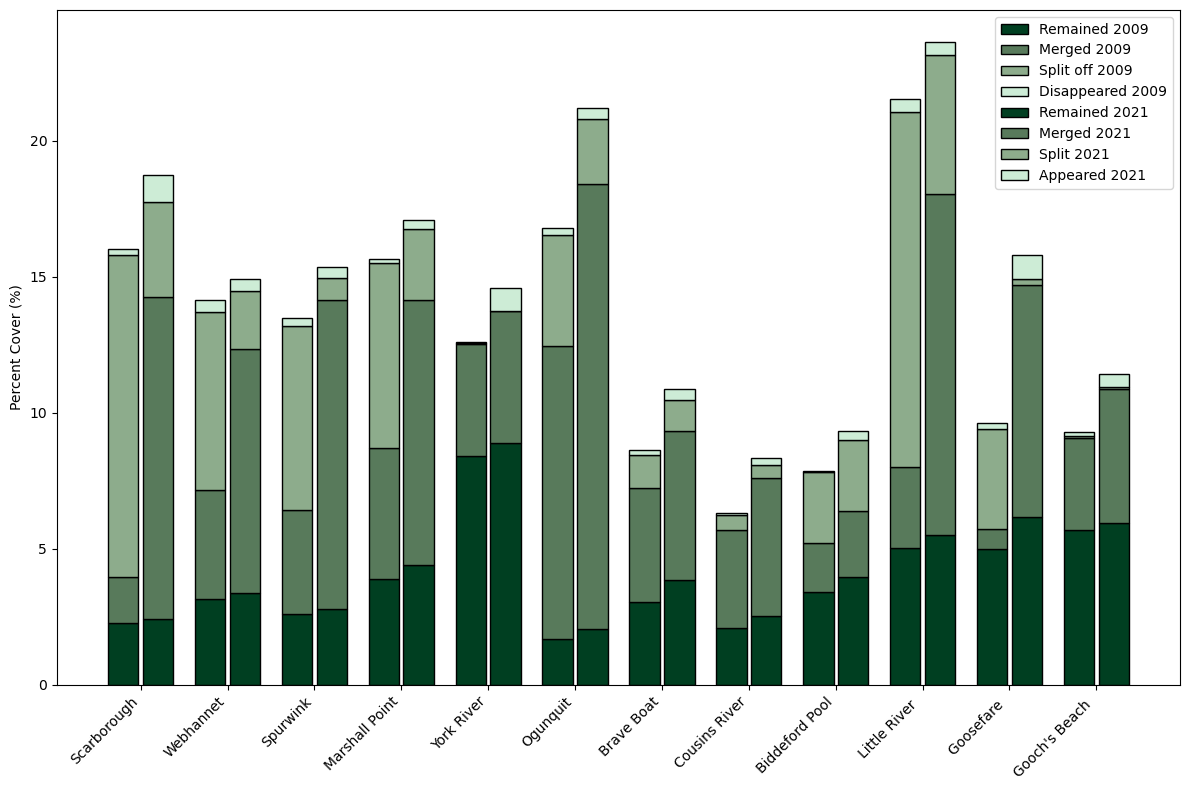

In [25]:
# Sort DataFrame by marsh_number
df.sort_values(by='marsh_number', inplace=True)

# Plotting function
def plot_stacked_bar(df):
    fig, ax = plt.subplots(figsize=(12, 8))

    # Width of each bar
    bar_width = 0.35
    bar_space = 0.05  # Space between 2009 and 2021 bars

    # Positions for bars on X axis
    ind = np.arange(len(df))

    # Stacked bars for 2009
    p1 = ax.bar(ind, df['Remained 2009'], bar_width, label='Remained 2009', color='#003f21', edgecolor='black')
    p2 = ax.bar(ind, df['Merged 2009'], bar_width, bottom=df['Remained 2009'], label='Merged 2009', color='#587a5b', edgecolor='black')
    p3 = ax.bar(ind, df['Split off 2009'], bar_width, bottom=df['Remained 2009'] + df['Merged 2009'], label='Split off 2009', color='#8dac8c', edgecolor='black')
    p4 = ax.bar(ind, df['Disappeared 2009'], bar_width, bottom=df['Remained 2009'] + df['Merged 2009'] + df['Split off 2009'], label='Disappeared 2009', color='#cdecd6', edgecolor='black')

    # Stacked bars for 2021
    p5 = ax.bar(ind + bar_width + bar_space, df['Remained 2021'], bar_width, label='Remained 2021', color='#003f21', edgecolor='black')
    p6 = ax.bar(ind + bar_width + bar_space, df['Merged 2021'], bar_width, bottom=df['Remained 2021'], label='Merged 2021', color='#587a5b', edgecolor='black')
    p7 = ax.bar(ind + bar_width + bar_space, df['Split 2021'], bar_width, bottom=df['Remained 2021'] + df['Merged 2021'], label='Split 2021', color='#8dac8c', edgecolor='black')
    p8 = ax.bar(ind + bar_width + bar_space, df['Appeared 2021'], bar_width, bottom=df['Remained 2021'] + df['Merged 2021'] + df['Split 2021'], label='Appeared 2021', color='#cdecd6', edgecolor='black')

    # Add labels, title, legend, and adjust layout
    ax.set_ylabel('Percent Cover (%)')
    ax.set_xticks(ind + (bar_width + bar_space) / 2)
    ax.set_xticklabels(df['MarshName'])
    ax.legend()

    # Rotate x-axis labels for better readability if needed
    plt.xticks(rotation=45, ha='right')

    # Show plot
    plt.tight_layout()
    plt.show()

# Plot the chart
plot_stacked_bar(df)

C:\Users\Classroom\AppData\Local\Temp\ipykernel_17296\1367888853.py:39: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  handles = [patches.Rectangle((0, 0), 1, 1, color='white', edgecolor='black', linewidth=0), p8[0], p4[0], p3[0], p2[0], p1[0]]


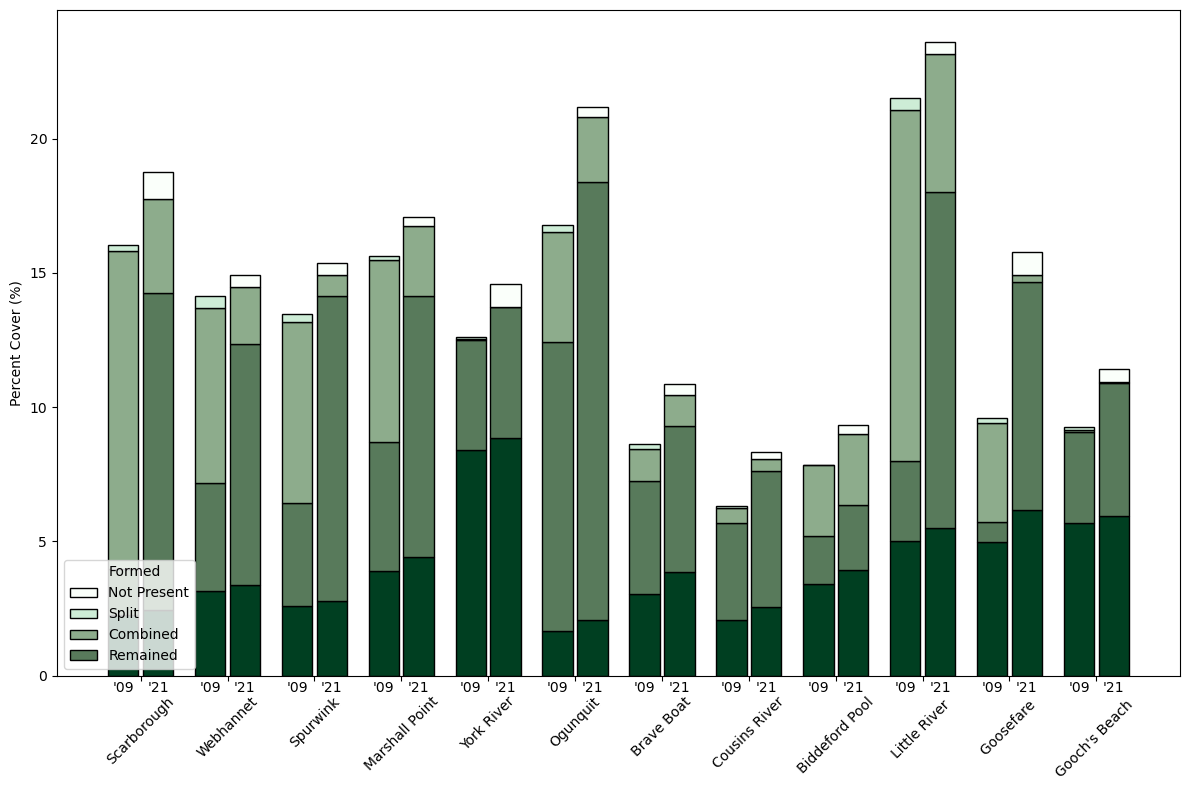

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches  # Import patches for Rectangle

# Sort DataFrame by marsh_number
df.sort_values(by='marsh_number', inplace=True)

# Plotting function
def plot_stacked_bar(df):
    fig, ax = plt.subplots(figsize=(12, 8))

    # Width of each bar
    bar_width = 0.35
    bar_space = 0.05  # Space between 2009 and 2021 bars

    # Positions for bars on X axis
    ind = np.arange(len(df))

    # Stacked bars for 2009
    p1 = ax.bar(ind, df['Remained 2009'], bar_width, label='Remained', color='#003f21', edgecolor='black')
    p2 = ax.bar(ind, df['Merged 2009'], bar_width, bottom=df['Remained 2009'], label='Combined', color='#587a5b', edgecolor='black')
    p3 = ax.bar(ind, df['Split off 2009'], bar_width, bottom=df['Remained 2009'] + df['Merged 2009'], label='Split', color='#8dac8c', edgecolor='black')
    p4 = ax.bar(ind, df['Disappeared 2009'], bar_width, bottom=df['Remained 2009'] + df['Merged 2009'] + df['Split off 2009'], label='Not Present', color='#cdecd6', edgecolor='black')

    # Stacked bars for 2021
    p5 = ax.bar(ind + bar_width + bar_space, df['Remained 2021'], bar_width, label='Formed', color='#003f21', edgecolor='black')
    p6 = ax.bar(ind + bar_width + bar_space, df['Merged 2021'], bar_width, bottom=df['Remained 2021'], color='#587a5b', edgecolor='black')
    p7 = ax.bar(ind + bar_width + bar_space, df['Split 2021'], bar_width, bottom=df['Remained 2021'] + df['Merged 2021'], color='#8dac8c', edgecolor='black')
    p8 = ax.bar(ind + bar_width + bar_space, df['Appeared 2021'], bar_width, bottom=df['Remained 2021'] + df['Merged 2021'] + df['Split 2021'], color='#fafffa', edgecolor='black')

    # Add labels, title, legend, and adjust layout
    ax.set_ylabel('Percent Cover (%)')
    ax.set_xticks(ind + (bar_width + bar_space) / 2)
    ax.set_xticklabels(df['MarshName'])  # Corrected to 'MarshName'
    
    # Adjust legend labels and handles
    legend_labels = ['Formed','Not Present','Split','Combined','Remained']
    handles = [patches.Rectangle((0, 0), 1, 1, color='white', edgecolor='black', linewidth=0), p8[0], p4[0], p3[0], p2[0], p1[0]]
    ax.legend(handles, legend_labels, loc='lower left')

    # Rotate x-axis labels for better readability if needed
    plt.xticks(rotation=45, ha='center', va='top')
    plt.tick_params(axis='x', which='major', pad=10)

    # Add labels for years below each bar
    for i, (bar2009, bar2021) in enumerate(zip(p4, p8)):
        ax.text(bar2009.get_x() + bar2009.get_width() / 2, -0.2, "'09", ha='center', va='top', fontsize=10)
        ax.text(bar2021.get_x() + bar2021.get_width() / 2, -0.2, "'21", ha='center', va='top', fontsize=10)

    # Show plot
    plt.tight_layout()
    plt.show()

# Plot the chart
plot_stacked_bar(df)


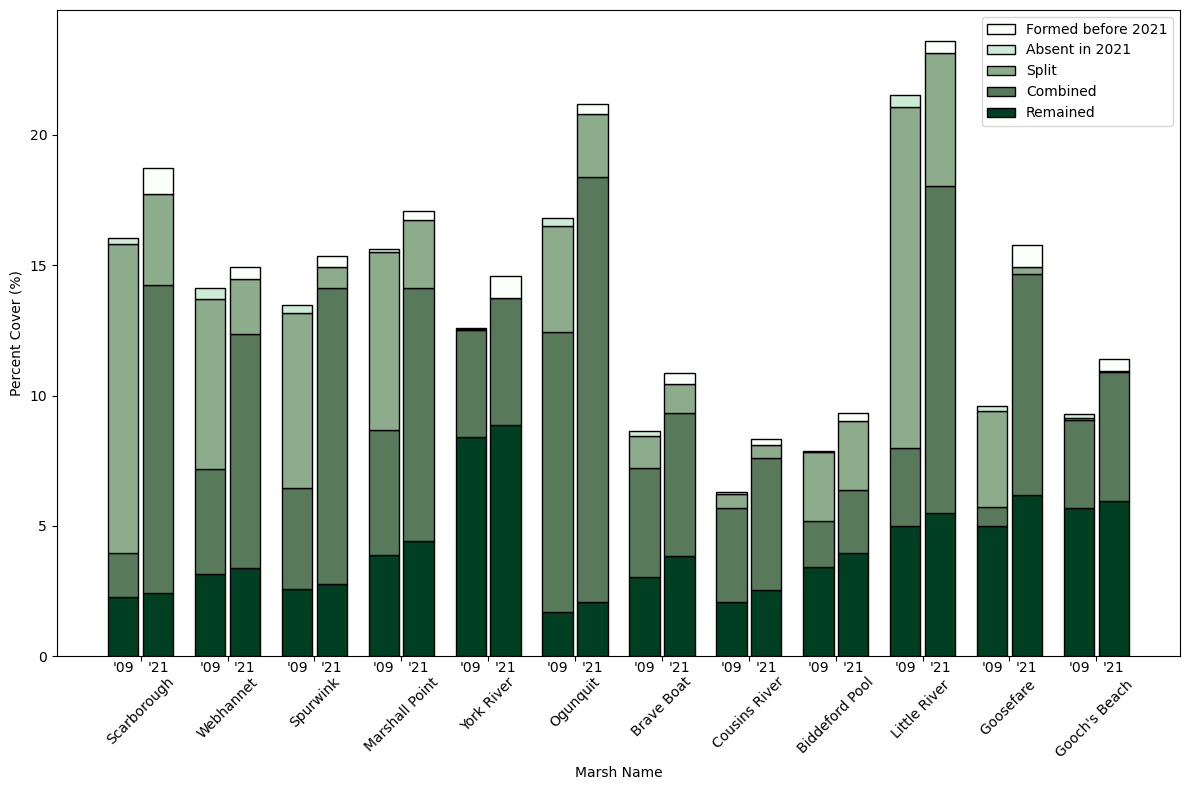

In [27]:
# Sort DataFrame by marsh_number
df.sort_values(by='marsh_number', inplace=True)

# Plotting function
def plot_stacked_bar(df):
    fig, ax = plt.subplots(figsize=(12, 8))

    # Width of each bar
    bar_width = 0.35
    bar_space = 0.05  # Space between 2009 and 2021 bars

    # Positions for bars on X axis
    ind = np.arange(len(df))

    # Stacked bars for 2009
    p1 = ax.bar(ind, df['Remained 2009'], bar_width, label='Remained', color='#003f21', edgecolor='black')
    p2 = ax.bar(ind, df['Merged 2009'], bar_width, bottom=df['Remained 2009'], label='Combined', color='#587a5b', edgecolor='black')
    p3 = ax.bar(ind, df['Split off 2009'], bar_width, bottom=df['Remained 2009'] + df['Merged 2009'], label='Split', color='#8dac8c', edgecolor='black')
    p4 = ax.bar(ind, df['Disappeared 2009'], bar_width, bottom=df['Remained 2009'] + df['Merged 2009'] + df['Split off 2009'], label='Absent in 2021', color='#cdecd6', edgecolor='black')

    # Stacked bars for 2021
    p5 = ax.bar(ind + bar_width + bar_space, df['Remained 2021'], bar_width, label='Remained', color='#003f21', edgecolor='black')
    p6 = ax.bar(ind + bar_width + bar_space, df['Merged 2021'], bar_width, bottom=df['Remained 2021'], color='#587a5b', edgecolor='black')
    p7 = ax.bar(ind + bar_width + bar_space, df['Split 2021'], bar_width, bottom=df['Remained 2021'] + df['Merged 2021'], color='#8dac8c', edgecolor='black')
    p8 = ax.bar(ind + bar_width + bar_space, df['Appeared 2021'], bar_width, bottom=df['Remained 2021'] + df['Merged 2021'] + df['Split 2021'], label='Formed before 2021', color='#fafffa', edgecolor='black')

    # Add labels, title, legend, and adjust layout
    ax.set_xlabel('Marsh Name')
    ax.set_ylabel('Percent Cover (%)')
    ax.set_xticks(ind + (bar_width + bar_space) / 2)
    ax.set_xticklabels(df['MarshName'])  # Corrected to 'MarshName'
    
    # Adjust legend labels and handles
    legend_labels = ['Formed before 2021','Absent in 2021','Split','Combined','Remained']
    handles = [
       # patches.Rectangle((0, 0), 1, 1, color='white', linewidth=0),
        p8[0],
        p4[0],
        p3[0],
        p2[0],
        p1[0]
    ]
    ax.legend(handles, legend_labels, loc='upper right')

    # Rotate x-axis labels for better readability if needed
    plt.xticks(rotation=45, ha='center', va='top')
    plt.tick_params(axis='x', which='major', pad=10)

    # Add labels for years below each bar
    for i, (bar2009, bar2021) in enumerate(zip(p4, p8)):
        ax.text(bar2009.get_x() + bar2009.get_width() / 2, -0.2, "'09", ha='center', va='top', fontsize=10)
        ax.text(bar2021.get_x() + bar2021.get_width() / 2, -0.2, "'21", ha='center', va='top', fontsize=10)

    # Show plot
    plt.tight_layout()
    plt.show()

# Plot the chart
plot_stacked_bar(df)

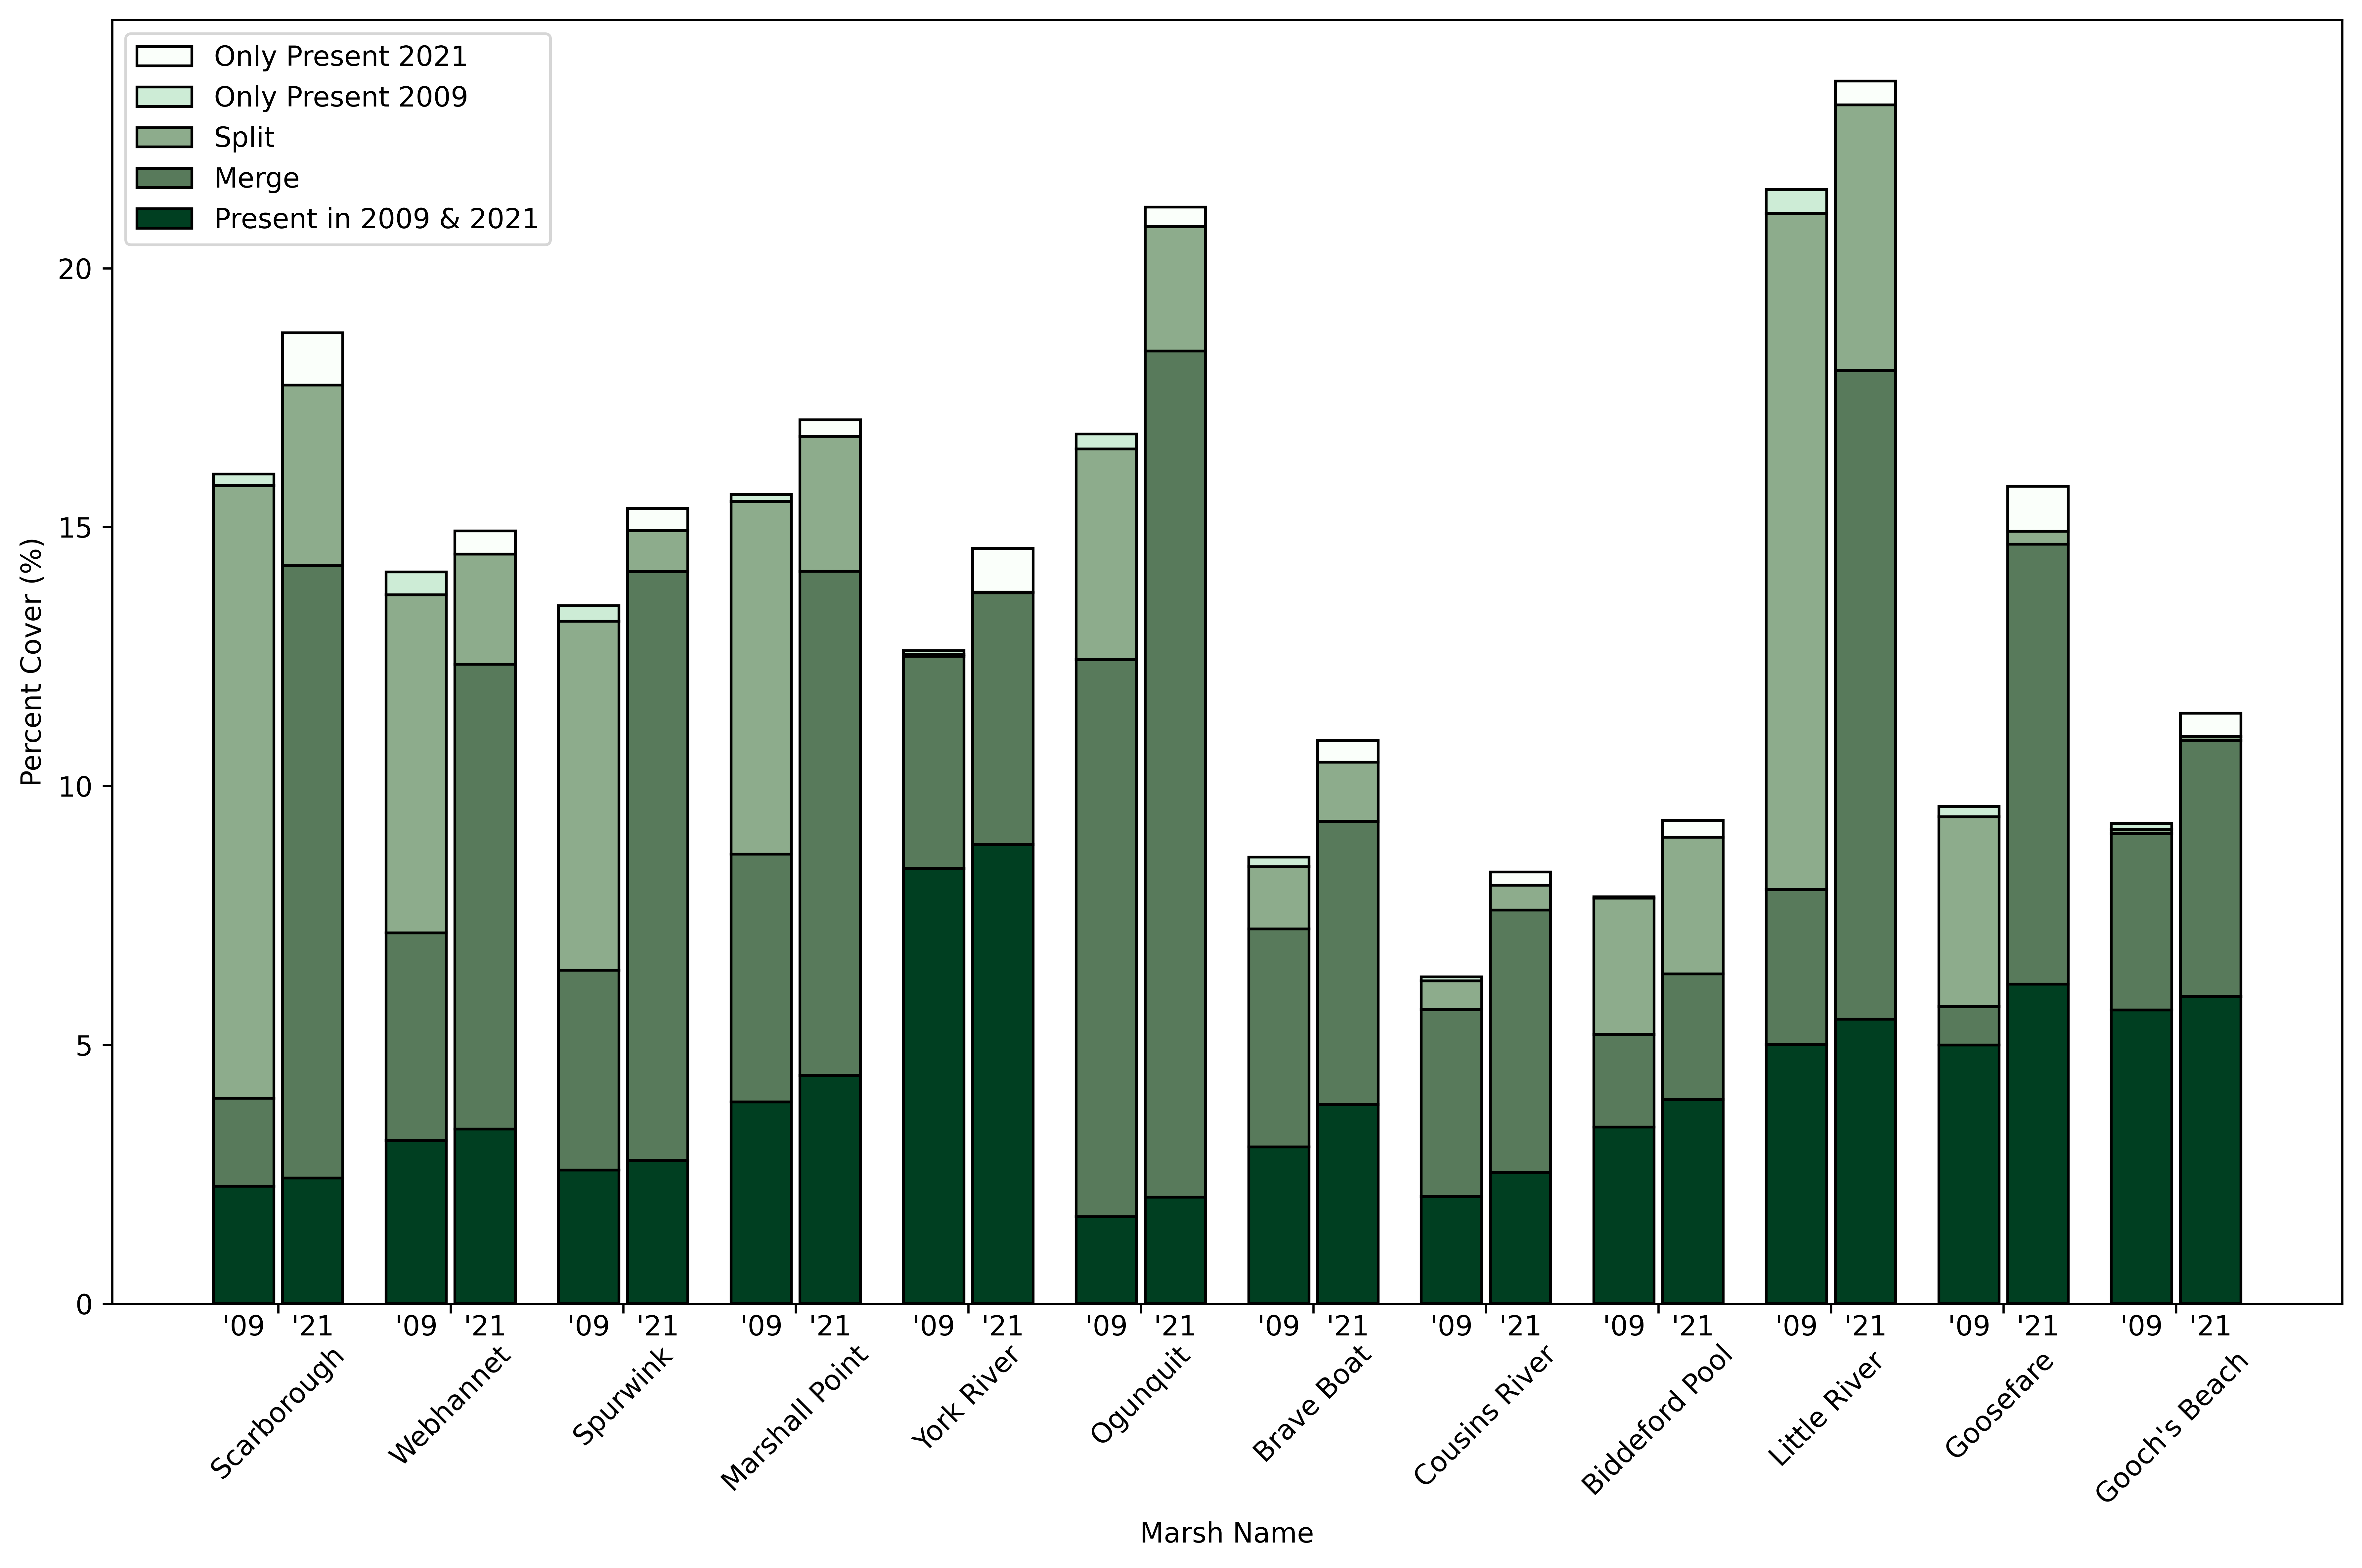

In [35]:
# Plotting function
def plot_stacked_bar(df):
    fig, ax = plt.subplots(figsize=(12, 8), dpi=600)  # Set DPI to 600

    # Width of each bar
    bar_width = 0.35
    bar_space = 0.05  # Space between 2009 and 2021 bars

    # Positions for bars on X axis
    ind = np.arange(len(df))

    # Stacked bars for 2009
    p1 = ax.bar(ind, df['Remained 2009'], bar_width, label='Remained', color='#003f21', edgecolor='black')
    p2 = ax.bar(ind, df['Merged 2009'], bar_width, bottom=df['Remained 2009'], label='Combined', color='#587a5b', edgecolor='black')
    p3 = ax.bar(ind, df['Split off 2009'], bar_width, bottom=df['Remained 2009'] + df['Merged 2009'], label='Split', color='#8dac8c', edgecolor='black')
    p4 = ax.bar(ind, df['Disappeared 2009'], bar_width, bottom=df['Remained 2009'] + df['Merged 2009'] + df['Split off 2009'], label='Only Present 2009', color='#cdecd6', edgecolor='black')

    # Stacked bars for 2021
    p5 = ax.bar(ind + bar_width + bar_space, df['Remained 2021'], bar_width, label='Remained', color='#003f21', edgecolor='black')
    p6 = ax.bar(ind + bar_width + bar_space, df['Merged 2021'], bar_width, bottom=df['Remained 2021'], color='#587a5b', edgecolor='black')
    p7 = ax.bar(ind + bar_width + bar_space, df['Split 2021'], bar_width, bottom=df['Remained 2021'] + df['Merged 2021'], color='#8dac8c', edgecolor='black')
    p8 = ax.bar(ind + bar_width + bar_space, df['Appeared 2021'], bar_width, bottom=df['Remained 2021'] + df['Merged 2021'] + df['Split 2021'], label='Only Present 2021', color='#fafffa', edgecolor='black')

    # Add labels, title, legend, and adjust layout
    ax.set_xlabel('Marsh Name')
    ax.set_ylabel('Percent Cover (%)')
    ax.set_xticks(ind + (bar_width + bar_space) / 2)
    ax.set_xticklabels(df['MarshName'])

    # Adjust legend labels and handles
    legend_labels = ['Only Present 2021', 'Only Present 2009', 'Split', 'Merge', 'Present in 2009 & 2021']
    handles = [
        p8[0],
        p4[0],
        p3[0],
        p2[0],
        p1[0]
    ]
    ax.legend(handles, legend_labels, loc='upper left')

    # Rotate x-axis labels for better readability if needed
    plt.xticks(rotation=45, ha='center', va='top')
    plt.tick_params(axis='x', which='major', pad=10)

    # Add labels for years below each bar
    for i, (bar2009, bar2021) in enumerate(zip(p4, p8)):
        ax.text(bar2009.get_x() + bar2009.get_width() / 2, -0.2, "'09", ha='center', va='top', fontsize=10)
        ax.text(bar2021.get_x() + bar2021.get_width() / 2, -0.2, "'21", ha='center', va='top', fontsize=10)

    # Show plot
    plt.tight_layout()

    # Save the plot with 600 DPI to the specified directory
    save_path = r"D:\Users\Classroom\Desktop\Katie summer 2023\Salt_marsh_digitization\Manuscript\Figures_final\intersection\stacked_bar_plot_600dpi.png"
    fig.savefig(save_path, dpi=600)

    # Display the plot
    plt.show()

# Plot the chart
plot_stacked_bar(df)

In [29]:
import pandas as pd

# Assuming 'df' is your DataFrame variable holding your data

# Set options to display all rows and columns
pd.set_option('display.max_rows', None)  # Display all rows
pd.set_option('display.max_columns', None)  # Display all columns

# Print the entire DataFrame
print(df)

# Save the DataFrame to a CSV file
file_path = r"D:\Users\Classroom\Desktop\Katie summer 2023\Salt_marsh_digitization\spreadsheets\INTERSECTION_PERC_COVER_DATA.csv"
df.to_csv(file_path, index=False)


    marsh_number    marsh_area          marsh_name  Disappeared 2009  \
6              1  1.007937e+07     Scarborough (1)          0.224333   
8              2  4.875870e+06       Webhannet (2)          0.442948   
5              3  1.971785e+06        Spurwink (3)          0.297264   
3              4  1.604381e+06  Marshall Point (4)          0.136230   
10             5  1.594480e+06      York River (5)          0.066489   
7              6  1.311597e+06        Ogunquit (6)          0.287800   
9              7  1.062555e+06      Brave Boat (7)          0.182235   
0              8  8.574721e+05   Cousins River (8)          0.079693   
11             9  8.055989e+05  Biddeford Pool (9)          0.025303   
4             10  8.674706e+05   Little River (10)          0.458793   
2             11  7.147104e+05      Goosefare (11)          0.193780   
1             12  4.431238e+05  Gooch's Beach (12)          0.120883   

    Appeared 2021  Remained 2009  Remained 2021  Merged 2009  S

In [30]:
# Calculate change percentages and add new columns
df['Remained Change Percent Cover'] = (df['Remained 2021'] - df['Remained 2009']) / df['Remained 2009']*100
df['Combined Change Percent Cover'] = (df['Merged 2021'] - df['Merged 2009']) / df['Merged 2009']*100
df['Split Change Percent Cover'] = (df['Split 2021'] - df['Split off 2009']) / df['Split off 2009']*100
df['Disappeared Change Percent Cover'] = (df['Appeared 2021'] - df['Disappeared 2009']) / df['Disappeared 2009']*100

# Display the updated DataFrame
print(df)

    marsh_number    marsh_area          marsh_name  Disappeared 2009  \
6              1  1.007937e+07     Scarborough (1)          0.224333   
8              2  4.875870e+06       Webhannet (2)          0.442948   
5              3  1.971785e+06        Spurwink (3)          0.297264   
3              4  1.604381e+06  Marshall Point (4)          0.136230   
10             5  1.594480e+06      York River (5)          0.066489   
7              6  1.311597e+06        Ogunquit (6)          0.287800   
9              7  1.062555e+06      Brave Boat (7)          0.182235   
0              8  8.574721e+05   Cousins River (8)          0.079693   
11             9  8.055989e+05  Biddeford Pool (9)          0.025303   
4             10  8.674706e+05   Little River (10)          0.458793   
2             11  7.147104e+05      Goosefare (11)          0.193780   
1             12  4.431238e+05  Gooch's Beach (12)          0.120883   

    Appeared 2021  Remained 2009  Remained 2021  Merged 2009  S

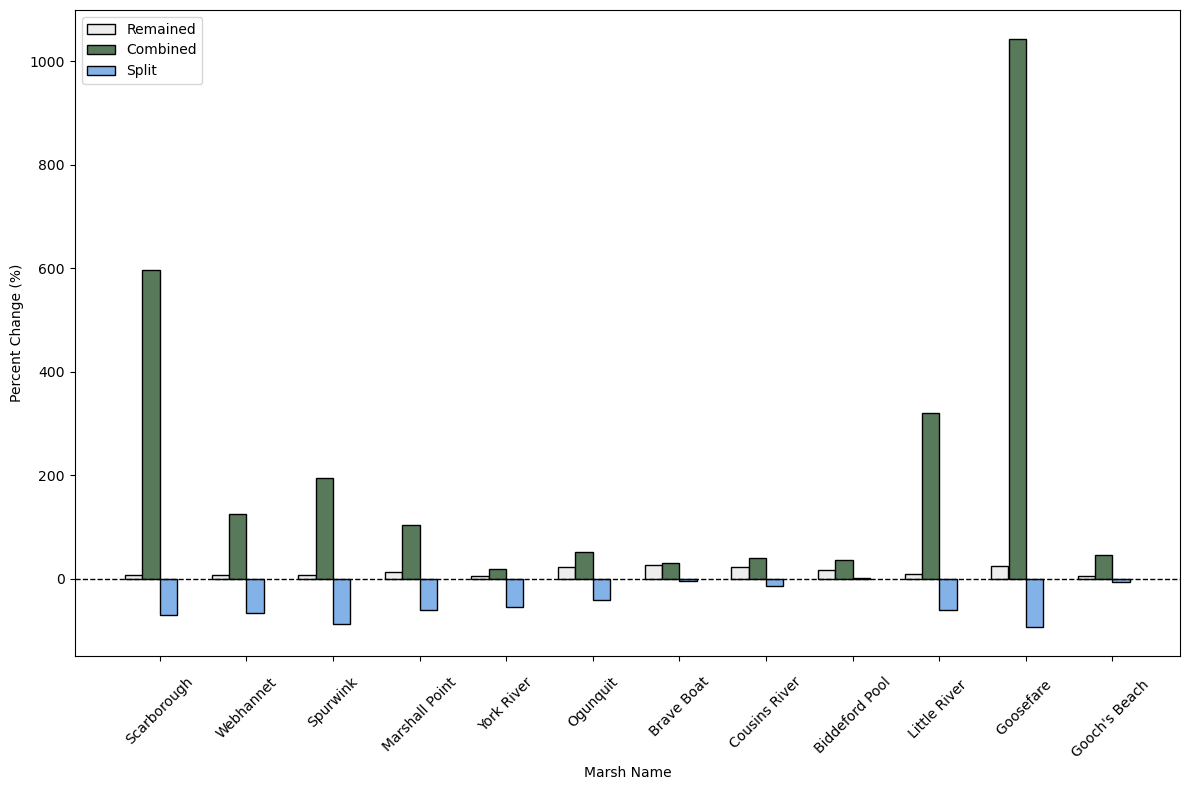

In [31]:
import matplotlib.pyplot as plt
import numpy as np

# Plotting function
def plot_change_percent_cover(df, save_path=None):
    # Set up the figure and axis
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Number of bars per group
    n = 4
    # Width of each bar
    bar_width = 0.2
    # Positions for bars on X axis
    ind = np.arange(len(df))

    # Plot bars for each category
    p1 = ax.bar(ind - 1.5 * bar_width, df['Remained Change Percent Cover'], bar_width, label='Remained', color='#ededed', edgecolor='black')
    p2 = ax.bar(ind - 0.5 * bar_width, df['Combined Change Percent Cover'], bar_width, label='Combined', color='#587a5b', edgecolor='black')
    p3 = ax.bar(ind + 0.5 * bar_width, df['Split Change Percent Cover'], bar_width, label='Split', color='#83b2e9', edgecolor='black')
    # p4 = ax.bar(ind + 1.5 * bar_width, df['Disappeared Change Percent Cover'], bar_width, label='Disappeared to Appeared', color='purple')
    
    # Add horizontal line at y=0
    ax.axhline(y=0, color='black', linestyle='--', linewidth=1)
    
    # Add labels, title, legend, and adjust layout
    ax.set_ylabel('Percent Change (%)')
    ax.set_xlabel('Marsh Name')
    ax.set_xticks(ind)
    ax.set_xticklabels(df['MarshName'])
    ax.legend(loc='upper left')

    # Rotate x-axis labels for better readability if needed
    plt.xticks(rotation=45, ha='center', va='top')
    plt.tick_params(axis='x', which='major', pad=10)

    # Show plot
    plt.tight_layout()
    
    # Save plot if save_path is provided
    if save_path:
        plt.savefig(save_path, dpi=600)
    
    plt.show()

# Example usage:
# Assuming df is your DataFrame containing the data
# Adjust df to your actual DataFrame variable
plot_change_percent_cover(df, save_path=r"D:\Users\Classroom\Desktop\Katie summer 2023\Salt_marsh_digitization\Manuscript\Figures_final\intersection\plot.png")


In [32]:

# Plotting function
def plot_change_percent_cover(df):
    # Set up the figure and axis
    fig, ax = plt.subplots(figsize=(12, 8))
#     # Set y-axis to log scale
#     ax.set_yscale('log')
    # Number of bars per group
    n = 4
    # Width of each bar
    bar_width = 0.2
    # Positions for bars on X axis
    ind = np.arange(len(df))

    # Plot bars for each category
    p1 = ax.bar(ind - 1.5 * bar_width, df['Remained Change Percent Cover'], bar_width, label='Remained', color='#ededed', edgecolor='black')
    p2 = ax.bar(ind - 0.5 * bar_width, df['Combined Change Percent Cover'], bar_width, label='Combined', color='#587a5b', edgecolor='black')
    p3 = ax.bar(ind + 0.5 * bar_width, df['Split Change Percent Cover'], bar_width, label='Split', color='#83b2e9, edgecolor='black')
    #p4 = ax.bar(ind + 1.5 * bar_width, df['Disappeared Change Percent Cover'], bar_width, label='Disappeared to Appeared', color='purple')
    # Add horizontal line at y=0
    ax.axhline(y=0, color='black', linestyle='--', linewidth=1)
    # Add labels, title, legend, and adjust layout
    ax.set_ylabel('Percent Change (%)')
    ax.set_title('Change in Percent Cover by MarshName')
    ax.set_xlabel('Marsh Name')
    ax.set_xticks(ind)
    ax.set_xticklabels(df['MarshName'])
    ax.legend(loc='upper left')

    # Rotate x-axis labels for better readability if needed
    plt.xticks(rotation=45, ha='center', va='top')
    plt.tick_params(axis='x', which='major', pad=10)

    # Show plot
    plt.tight_layout()
    plt.show()

# Plot the chart
plot_change_percent_cover(df)

SyntaxError: unterminated string literal (detected at line 17) (115742301.py, line 17)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Assuming df is already defined and contains the required data

# Plotting function
def plot_change_percent_cover(df):
    # Set up the figure and axis
    fig, ax = plt.subplots(figsize=(12, 8))

    # Number of bars per group
    n = 4
    # Width of each bar
    bar_width = 0.2
    # Positions for bars on X axis
    ind = np.arange(len(df))

    # Plot bars for each category
    p1 = ax.bar(ind - 1.5 * bar_width, df['Remained Change Percent Cover'], bar_width, label='Remained', color='red')
    p2 = ax.bar(ind - 0.5 * bar_width, df['Combined Change Percent Cover'], bar_width, label='Combined', color='green')
    p3 = ax.bar(ind + 0.5 * bar_width, df['Split Change Percent Cover'], bar_width, label='Split', color='blue')
    #p4 = ax.bar(ind + 1.5 * bar_width, df['Disappeared Change Percent Cover'], bar_width, label='Disappeared to Appeared', color='purple')

    # Set y-axis to log scale
    ax.set_yscale('log')

    # Add horizontal line at y=0
    ax.axhline(y=1, color='black', linestyle='--', linewidth=1)  # Log scale cannot have y=0

    # Add labels, title, legend, and adjust layout
    ax.set_ylabel('Percent Change')
    ax.set_title('Change in Percent Cover by MarshName')
    ax.set_xticks(ind)
    ax.set_xticklabels(df['MarshName'])
    ax.legend(loc='upper left')

    # Rotate x-axis labels for better readability if needed
    plt.xticks(rotation=45, ha='center', va='top')
    plt.tick_params(axis='x', which='major', pad=10)

    # Show plot
    plt.tight_layout()
    plt.show()

# Example data frame
data = {
    'MarshName': ['Marsh1', 'Marsh2', 'Marsh3', 'Marsh4'],
    'Remained Change Percent Cover': [0.1, 10, 0.5, 100],
    'Combined Change Percent Cover': [1, 20, 2, 200],
    'Split Change Percent Cover': [0.01, 5, 0.2, 50]
}

df = pd.DataFrame(data)

# Plot the chart
plot_change_percent_cover(df)


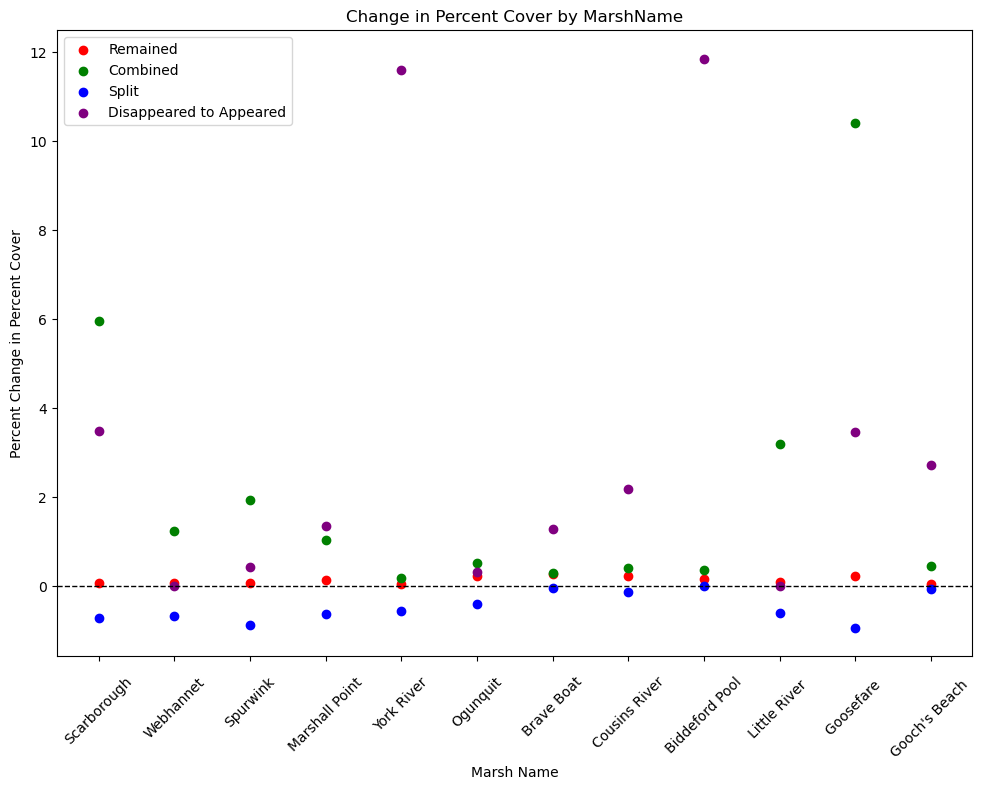

In [297]:
# Plotting function for scatter plot
def plot_scatter_change_percent_cover(df):
    fig, ax = plt.subplots(figsize=(10, 8))

    # Scatter plots for each category
    ax.scatter(df['MarshName'], df['Remained Change Percent Cover'], label='Remained', color='red')
    ax.scatter(df['MarshName'], df['Combined Change Percent Cover'], label='Combined', color='green')
    ax.scatter(df['MarshName'], df['Split Change Percent Cover'], label='Split', color='blue')
    ax.scatter(df['MarshName'], df['Disappeared Change Percent Cover'], label='Disappeared to Appeared', color='purple')
    # Add horizontal line at y=0
    ax.axhline(y=0, color='black', linestyle='--', linewidth=1)
    # Add labels and title
    ax.set_xlabel('Marsh Name')
    ax.set_ylabel('Percent Change in Percent Cover')
    ax.set_title('Change in Percent Cover by MarshName')

    # Rotate x-axis labels for better readability if needed
    plt.xticks(rotation=45, ha='center', va='top')
    plt.tick_params(axis='x', which='major', pad=10)

    # Add legend
    ax.legend()

    # Show plot
    plt.tight_layout()
    plt.show()

# Plot the scatter chart
plot_scatter_change_percent_cover(df)

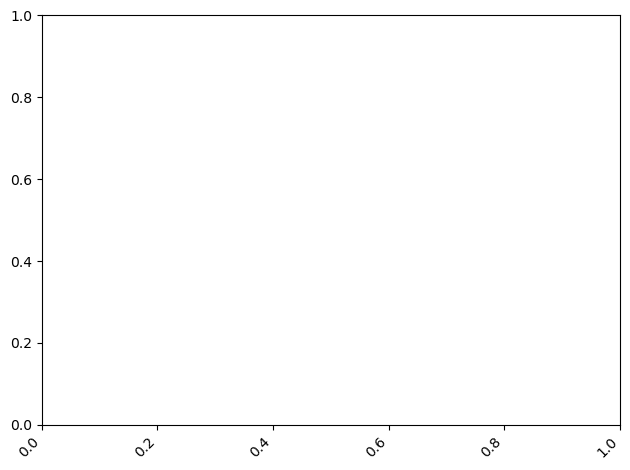

In [238]:
# Width of each bar
bar_width = 0.35

# Positions for bars on X axis
ind = range(len(df))

# Stacked bars for 2009
p1 = ax.bar(ind, df['Remained 2009'], bar_width, label='Remained 2009')
p2 = ax.bar(ind, df['Merged 2009'], bar_width, bottom=df['Remained 2009'], label='Merged 2009')
p3 = ax.bar(ind, df['Split off 2009'], bar_width, bottom=df['Remained 2009'] + df['Merged 2009'], label='Split off 2009')
p4 = ax.bar(ind, df['Disappeared 2009'], bar_width, bottom=df['Remained 2009'] + df['Merged 2009'] + df['Split off 2009'], label='Disappeared 2009')

# Stacked bars for 2021
p5 = ax.bar([i + bar_width for i in ind], df['Remained 2021'], bar_width, label='Remained 2021')
p6 = ax.bar([i + bar_width for i in ind], df['Merged 2021'], bar_width, bottom=df['Remained 2021'], label='Merged 2021')
p7 = ax.bar([i + bar_width for i in ind], df['Split 2021'], bar_width, bottom=df['Remained 2021'] + df['Merged 2021'], label='Split 2021')
p8 = ax.bar([i + bar_width for i in ind], df['Appeared 2021'], bar_width, bottom=df['Remained 2021'] + df['Merged 2021'] + df['Split 2021'], label='Appeared 2021')

# Add labels, title, legend, and adjust layout
ax.set_ylabel('Percent Cover')
ax.set_title('Percent Cover by marsh_name and Year')
ax.set_xticks([i + bar_width / 2 for i in ind])
ax.set_xticklabels(df.index)
ax.legend()

# Rotate x-axis labels for better readability if needed
plt.xticks(rotation=45, ha='right')

# Show plot
plt.tight_layout()
plt.show() 

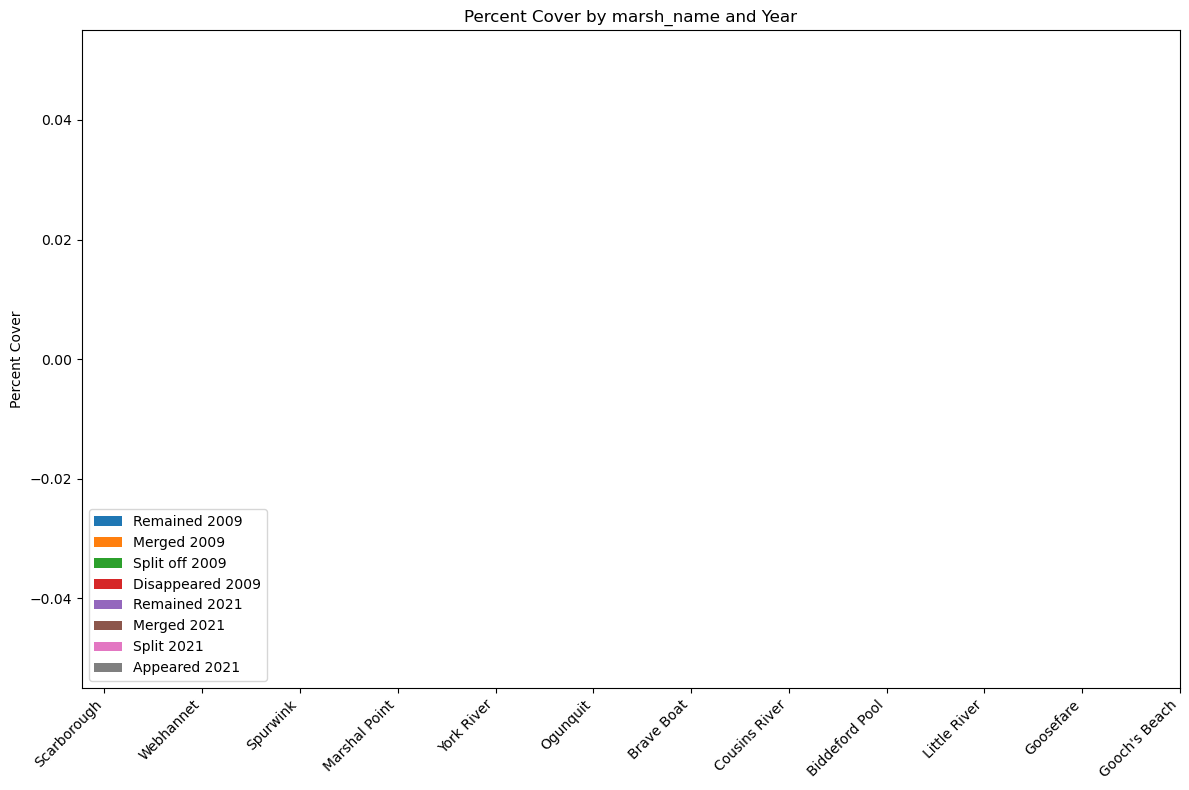

In [237]:
# Set marsh_name as index
df.set_index('marsh_name', inplace=True)

# Desired order of marsh names
desired_order = ['Scarborough', 'Webhannet', 'Spurwink', 'Marshal Point', 'York River', 'Ogunquit', 'Brave Boat', 'Cousins River', 'Biddeford Pool', 'Little River', 'Goosefare', "Gooch's Beach"]

# Reindex the DataFrame to match the desired order
df = df.reindex(desired_order)

# Plotting function
def plot_stacked_bar(df):
    fig, ax = plt.subplots(figsize=(12, 8))

    # Width of each bar
    bar_width = 0.35

    # Positions for bars on X axis
    ind = range(len(df))

    # Stacked bars for 2009
    p1 = ax.bar(ind, df['Remained 2009'], bar_width, label='Remained 2009')
    p2 = ax.bar(ind, df['Merged 2009'], bar_width, bottom=df['Remained 2009'], label='Merged 2009')
    p3 = ax.bar(ind, df['Split off 2009'], bar_width, bottom=df['Remained 2009'] + df['Merged 2009'], label='Split off 2009')
    p4 = ax.bar(ind, df['Disappeared 2009'], bar_width, bottom=df['Remained 2009'] + df['Merged 2009'] + df['Split off 2009'], label='Disappeared 2009')

    # Stacked bars for 2021
    p5 = ax.bar([i + bar_width for i in ind], df['Remained 2021'], bar_width, label='Remained 2021')
    p6 = ax.bar([i + bar_width for i in ind], df['Merged 2021'], bar_width, bottom=df['Remained 2021'], label='Merged 2021')
    p7 = ax.bar([i + bar_width for i in ind], df['Split 2021'], bar_width, bottom=df['Remained 2021'] + df['Merged 2021'], label='Split 2021')
    p8 = ax.bar([i + bar_width for i in ind], df['Appeared 2021'], bar_width, bottom=df['Remained 2021'] + df['Merged 2021'] + df['Split 2021'], label='Appeared 2021')

    # Add labels, title, legend, and adjust layout
    ax.set_ylabel('Percent Cover')
    ax.set_title('Percent Cover by marsh_name and Year')
    ax.set_xticks([i + bar_width / 2 for i in ind])
    ax.set_xticklabels(df.index)
    ax.legend()

    # Rotate x-axis labels for better readability if needed
    plt.xticks(rotation=45, ha='right')

    # Show plot
    plt.tight_layout()
    plt.show()

# Plot the chart
plot_stacked_bar(df)



# # If you need to re-run the plot, reset the index to avoid 'marsh_name' not found error
# df.reset_index(inplace=True)
# # Example of resetting columns and then re-plotting
# df = pd.DataFrame(data)  # Recreate DataFrame or reset columns if necessary
# plot_stacked_bar(df)

In [ ]:
# above is percent cover, below is pools/km2

In [183]:
# Define the file path (change this to your actual file path)
file_path = r'D:\Users\Classroom\Desktop\Katie summer 2023\Salt_marsh_digitization\spreadsheets\Marsh_areas.xlsx'

# Load the Excel file
xls = pd.ExcelFile(file_path)

# Print sheet names to check the structure of the Excel file
print(xls.sheet_names)

# Assuming the data is in the first sheet
sheet_name = xls.sheet_names[0]

# Load the data into a DataFrame
df = pd.read_excel(file_path, sheet_name=sheet_name)

# Display the first few rows of the DataFrame
print(df.head())

# Rename columns if needed
df1 = df.rename(columns={'marsh_number': 'marsh_number', 'marsh_area': 'marsh_area', 'marsh_name': 'marsh_name'})

# Display the DataFrame with the new column names (df1)
print(df1.head())

['Sheet1']
   marsh_number    marsh_area          marsh_name
0             8  8.574721e+05   Cousins River (8)
1            12  4.431238e+05  Gooch's Beach (12)
2            11  7.147104e+05      Goosefare (11)
3             4  1.604381e+06  Marshall Point (4)
4            10  8.674706e+05   Little River (10)
   marsh_number    marsh_area          marsh_name
0             8  8.574721e+05   Cousins River (8)
1            12  4.431238e+05  Gooch's Beach (12)
2            11  7.147104e+05      Goosefare (11)
3             4  1.604381e+06  Marshall Point (4)
4            10  8.674706e+05   Little River (10)


In [184]:
# Path to the GeoPackage file
gpkg_file_path = r"D:\Users\Classroom\Desktop\Katie summer 2023\Salt_marsh_digitization\INTERSECTION\WithPercentCover\disapeared_between_2009_and_2021_percent_cover.gpkg"

# Load the GeoPackage file
gdf = gpd.read_file(gpkg_file_path)

# Group by 'marsh_number' and count the number of rows (pools) for each marsh_number
disappeared_count = gdf.groupby('marsh_number').size().reset_index(name='Disappeared 2009')

# Merge the counted values into the existing DataFrame df1
df1 = pd.merge(df1, disappeared_count, on='marsh_number', how='left')

# Fill NaN values in 'Disappeared 2009' column with 0 (assuming no data means 0 pools disappeared)
df1['Disappeared 2009'].fillna(0, inplace=True)

# Display the updated DataFrame df1
print(df1.head())

   marsh_number    marsh_area          marsh_name  Disappeared 2009
0             8  8.574721e+05   Cousins River (8)                25
1            12  4.431238e+05  Gooch's Beach (12)                15
2            11  7.147104e+05      Goosefare (11)                14
3             4  1.604381e+06  Marshall Point (4)                43
4            10  8.674706e+05   Little River (10)                81


In [185]:
# Path to the GeoPackage file
gpkg_file_path = r"D:\Users\Classroom\Desktop\Katie summer 2023\Salt_marsh_digitization\INTERSECTION\WithPercentCover\formed_between_2009_and_2021_percent_cover.gpkg"

# Load the GeoPackage file
gdf = gpd.read_file(gpkg_file_path)

# Group by 'marsh_number' and count the number of rows (pools) for each marsh_number
disappeared_count = gdf.groupby('marsh_number').size().reset_index(name='Appeared 2021')

# Merge the counted values into the existing DataFrame df1
df1 = pd.merge(df1, disappeared_count, on='marsh_number', how='left')

# Fill NaN values in 'Disappeared 2009' column with 0 (assuming no data means 0 pools appeared)
df1['Appeared 2021'].fillna(0, inplace=True)

# Display the updated DataFrame df1
print(df1.head())

   marsh_number    marsh_area          marsh_name  Disappeared 2009  \
0             8  8.574721e+05   Cousins River (8)                25   
1            12  4.431238e+05  Gooch's Beach (12)                15   
2            11  7.147104e+05      Goosefare (11)                14   
3             4  1.604381e+06  Marshall Point (4)                43   
4            10  8.674706e+05   Little River (10)                81   

   Appeared 2021  
0             96  
1             33  
2            132  
3            218  
4            260  


In [186]:
# Path to the GeoPackage file for the Remained 2009 data
gpkg_remained_path = r"D:\Users\Classroom\Desktop\Katie summer 2023\Salt_marsh_digitization\INTERSECTION\WithPercentCover\single_intersect_2009_percent_cover.gpkg"

# Load the GeoPackage file
gdf_remained = gpd.read_file(gpkg_remained_path)

# Count number of rows (pools) for each marsh_number
row_counts = gdf_remained.groupby('marsh_number').size().reset_index(name='Remained 2009')

# Merge the row counts into the existing DataFrame df1
df1 = df1.merge(row_counts, on='marsh_number', how='left')
df1['Remained 2009'].fillna(0, inplace=True)

# Display the updated DataFrame
print(df1.head())

   marsh_number    marsh_area          marsh_name  Disappeared 2009  \
0             8  8.574721e+05   Cousins River (8)                25   
1            12  4.431238e+05  Gooch's Beach (12)                15   
2            11  7.147104e+05      Goosefare (11)                14   
3             4  1.604381e+06  Marshall Point (4)                43   
4            10  8.674706e+05   Little River (10)                81   

   Appeared 2021  Remained 2009  
0             96            104  
1             33             36  
2            132             56  
3            218            275  
4            260            162  


In [187]:
# Path to the GeoPackage file for the Remained 2009 data
gpkg_remained_path = r"D:\Users\Classroom\Desktop\Katie summer 2023\Salt_marsh_digitization\INTERSECTION\WithPercentCover\single_intersect_2021_percent_cover.gpkg"

# Load the GeoPackage file
gdf_remained = gpd.read_file(gpkg_remained_path)

# Count number of rows (pools) for each marsh_number
row_counts = gdf_remained.groupby('marsh_number').size().reset_index(name='Remained 2021')

# Merge the row counts into the existing DataFrame df1
df1 = df1.merge(row_counts, on='marsh_number', how='left')
df1['Remained 2021'].fillna(0, inplace=True)

# Display the updated DataFrame
print(df1.head())

   marsh_number    marsh_area          marsh_name  Disappeared 2009  \
0             8  8.574721e+05   Cousins River (8)                25   
1            12  4.431238e+05  Gooch's Beach (12)                15   
2            11  7.147104e+05      Goosefare (11)                14   
3             4  1.604381e+06  Marshall Point (4)                43   
4            10  8.674706e+05   Little River (10)                81   

   Appeared 2021  Remained 2009  Remained 2021  
0             96            104            104  
1             33             36             36  
2            132             56             56  
3            218            275            275  
4            260            162            162  


In [188]:
# for merged/split touch counts consider only using MS or size limit to reduce GR errors
# TC 09 1=merged >1=split
# TC 21 1=split >1=merged
# split column = TC 21 > 1 sum percent cover
# merge column = TC 09 > 1 sum percent cover 

In [189]:
# Path to the GeoPackage file
gpkg_path = r"D:\Users\Classroom\Desktop\Katie summer 2023\Salt_marsh_digitization\INTERSECTION\WithPercentCover\merged_or_split_pools_2009_touch_count_percent_cover.gpkg"

# Load the GeoPackage file
gdf = gpd.read_file(gpkg_path)

# Count rows (pools) where touch_count_from_2021 is 1 for each marsh_number
merged_2009_counts = gdf[gdf['touch_count_from_2021'] == 1].groupby('marsh_number').size().reset_index(name='Merged 2009')

# Count rows (pools) where touch_count_from_2021 > 1 for each marsh_number
split_2009_counts = gdf[gdf['touch_count_from_2021'] > 1].groupby('marsh_number').size().reset_index(name='Split 2009')

# Merge the counts into the existing DataFrame df1
df1 = df1.merge(merged_2009_counts, on='marsh_number', how='left')
df1 = df1.merge(split_2009_counts, on='marsh_number', how='left')

# Fill NaN values with 0 in the new columns
df1['Merged 2009'].fillna(0, inplace=True)
df1['Split 2009'].fillna(0, inplace=True)

# Display the updated DataFrame
print(df1.head())

   marsh_number    marsh_area          marsh_name  Disappeared 2009  \
0             8  8.574721e+05   Cousins River (8)                25   
1            12  4.431238e+05  Gooch's Beach (12)                15   
2            11  7.147104e+05      Goosefare (11)                14   
3             4  1.604381e+06  Marshall Point (4)                43   
4            10  8.674706e+05   Little River (10)                81   

   Appeared 2021  Remained 2009  Remained 2021  Merged 2009  Split 2009  
0             96            104            104           20           6  
1             33             36             36           27           4  
2            132             56             56           36           9  
3            218            275            275           86          35  
4            260            162            162           87          25  


In [190]:
# Path to the GeoPackage file
gpkg_path = r"D:\Users\Classroom\Desktop\Katie summer 2023\Salt_marsh_digitization\INTERSECTION\WithPercentCover\merged_or_split_pools_2021_touch_count_percent_cover.gpkg"

# Load the GeoPackage file
gdf = gpd.read_file(gpkg_path)

# Count rows (pools) where touch_count_from_2021 is 1 for each marsh_number
split_2021_counts = gdf[gdf['touch_count_from_2009'] == 1].groupby('marsh_number').size().reset_index(name='Split 2021')

# Count rows (pools) where touch_count_from_2021 > 1 for each marsh_number
merged_2021_counts = gdf[gdf['touch_count_from_2009'] > 1].groupby('marsh_number').size().reset_index(name='Merged 2021')

# Merge the counts into the existing DataFrame df1
df1 = df1.merge(split_2021_counts, on='marsh_number', how='left')
df1 = df1.merge(merged_2021_counts, on='marsh_number', how='left')

# Fill NaN values with 0 in the new columns
df1['Split 2021'].fillna(0, inplace=True)
df1['Merged 2021'].fillna(0, inplace=True)

# Display the updated DataFrame
print(df1.head())

   marsh_number    marsh_area          marsh_name  Disappeared 2009  \
0             8  8.574721e+05   Cousins River (8)                25   
1            12  4.431238e+05  Gooch's Beach (12)                15   
2            11  7.147104e+05      Goosefare (11)                14   
3             4  1.604381e+06  Marshall Point (4)                43   
4            10  8.674706e+05   Little River (10)                81   

   Appeared 2021  Remained 2009  Remained 2021  Merged 2009  Split 2009  \
0             96            104            104           20           6   
1             33             36             36           27           4   
2            132             56             56           36           9   
3            218            275            275           86          35   
4            260            162            162           87          25   

   Split 2021  Merged 2021  
0          10            8  
1           6            9  
2          11           14  
3     

In [191]:

# Print column names of df1
print(df1.columns.tolist())

['marsh_number', 'marsh_area', 'marsh_name', 'Disappeared 2009', 'Appeared 2021', 'Remained 2009', 'Remained 2021', 'Merged 2009', 'Split 2009', 'Split 2021', 'Merged 2021']


In [192]:
# List of columns to process (excluding 'marsh_number', 'marsh_area', and 'marsh_name')
columns_to_process = [col for col in df1.columns if col not in ['marsh_number', 'marsh_area', 'marsh_name']]

# Divide each column by marsh_area and create new columns
for col in columns_to_process:
    new_col_name = f"{col} per km2"
    df1[new_col_name] = df1[col] / df1['marsh_area']*1000000

# Display the updated DataFrame
print(df1.head())

   marsh_number    marsh_area          marsh_name  Disappeared 2009  \
0             8  8.574721e+05   Cousins River (8)                25   
1            12  4.431238e+05  Gooch's Beach (12)                15   
2            11  7.147104e+05      Goosefare (11)                14   
3             4  1.604381e+06  Marshall Point (4)                43   
4            10  8.674706e+05   Little River (10)                81   

   Appeared 2021  Remained 2009  Remained 2021  Merged 2009  Split 2009  \
0             96            104            104           20           6   
1             33             36             36           27           4   
2            132             56             56           36           9   
3            218            275            275           86          35   
4            260            162            162           87          25   

   Split 2021  Merged 2021  Disappeared 2009 per km2  Appeared 2021 per km2  \
0          10            8                 

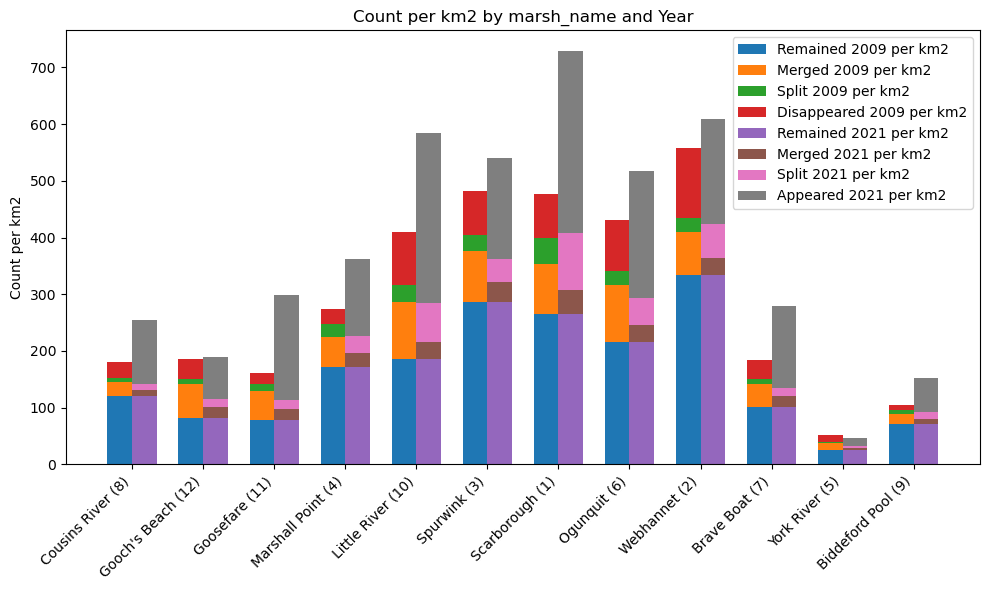

In [193]:
# Set marsh_name as index
df1.set_index('marsh_name', inplace=True)

# Plotting function
def plot_stacked_bar(df1):
    fig, ax = plt.subplots(figsize=(10, 6))

    # Width of each bar
    bar_width = 0.35

    # Positions for bars on X axis
    ind = range(len(df1))

    # Stacked bars for 2009
    p1 = ax.bar(ind, df1['Remained 2009 per km2'], bar_width, label='Remained 2009 per km2')
    p2 = ax.bar(ind, df1['Merged 2009 per km2'], bar_width, bottom=df1['Remained 2009 per km2'], label='Merged 2009 per km2')
    p3 = ax.bar(ind, df1['Split 2009 per km2'], bar_width, bottom=df1['Remained 2009 per km2'] + df1['Merged 2009 per km2'], label='Split 2009 per km2')
    p4 = ax.bar(ind, df1['Disappeared 2009 per km2'], bar_width, bottom=df1['Remained 2009 per km2'] + df1['Merged 2009 per km2'] + df1['Split 2009 per km2'], label='Disappeared 2009 per km2')

    # Stacked bars for 2021
    p5 = ax.bar([i + bar_width for i in ind], df1['Remained 2021 per km2'], bar_width, label='Remained 2021 per km2')
    p6 = ax.bar([i + bar_width for i in ind], df1['Merged 2021 per km2'], bar_width, bottom=df1['Remained 2021 per km2'], label='Merged 2021 per km2')
    p7 = ax.bar([i + bar_width for i in ind], df1['Split 2021 per km2'], bar_width, bottom=df1['Remained 2021 per km2'] + df1['Merged 2021 per km2'], label='Split 2021 per km2')
    p8 = ax.bar([i + bar_width for i in ind], df1['Appeared 2021 per km2'], bar_width, bottom=df1['Remained 2021 per km2'] + df1['Merged 2021 per km2'] + df1['Split 2021 per km2'], label='Appeared 2021 per km2')

    # Add labels, title, legend, and adjust layout
    ax.set_ylabel('Count per km2')
    ax.set_title('Count per km2 by marsh_name and Year')
    ax.set_xticks([i + bar_width / 2 for i in ind])
    ax.set_xticklabels(df1.index)
    ax.legend()

    # Rotate x-axis labels for better readability if needed
    plt.xticks(rotation=45, ha='right')

    # Show plot
    plt.tight_layout()
    plt.show()

# Initial plot
plot_stacked_bar(df1)

# If you need to re-run the plot, reset the index to avoid 'marsh_name' not found error
# df1.reset_index(inplace=True)

# Example of resetting columns and then re-plotting
# df1 = pd.DataFrame(data)  # Recreate DataFrame or reset columns if necessary
# plot_stacked_bar(df1)

In [69]:
from pathlib import Path

# Define the paths to your GeoPackage files
file_paths = [
    r"D:\Users\Classroom\Desktop\Katie summer 2023\Salt_marsh_digitization\INTERSECTION\WithPercentCover\disapeared_between_2009_and_2021_percent_cover.gpkg",
    r"D:\Users\Classroom\Desktop\Katie summer 2023\Salt_marsh_digitization\INTERSECTION\WithPercentCover\formed_between_2009_and_2021_percent_cover.gpkg",
    r"D:\Users\Classroom\Desktop\Katie summer 2023\Salt_marsh_digitization\INTERSECTION\WithPercentCover\merged_or_split_pools_2009_percent_cover.gpkg",
    r"D:\Users\Classroom\Desktop\Katie summer 2023\Salt_marsh_digitization\INTERSECTION\WithPercentCover\merged_or_split_pools_2009_touch_count_percent_cover.gpkg",
    r"D:\Users\Classroom\Desktop\Katie summer 2023\Salt_marsh_digitization\INTERSECTION\WithPercentCover\merged_or_split_pools_2021_percent_cover.gpkg",
    r"D:\Users\Classroom\Desktop\Katie summer 2023\Salt_marsh_digitization\INTERSECTION\WithPercentCover\merged_or_split_pools_2021_touch_count_percent_cover.gpkg",
    r"D:\Users\Classroom\Desktop\Katie summer 2023\Salt_marsh_digitization\INTERSECTION\WithPercentCover\single_intersect_2009_percent_cover.gpkg",
    r"D:\Users\Classroom\Desktop\Katie summer 2023\Salt_marsh_digitization\INTERSECTION\WithPercentCover\single_intersect_2021_percent_cover.gpkg"
]

# Initialize an empty DataFrame to collect results
result_df = pd.DataFrame(columns=['marsh_number', 'marsh_name', 'marsh_area'])

# Process each file
for file_path in file_paths:
    print(f"Processing file: {file_path}")
    
    # Read the GeoPackage file
    gdf = gpd.read_file(file_path)
    
    # Extract marsh_number, marsh_name, marsh_area from the GeoDataFrame
    if 'marsh_number' in gdf.columns and 'marsh_name' in gdf.columns and 'marsh_area' in gdf.columns:
        subset_df = gdf[['marsh_number', 'marsh_name', 'marsh_area']]
        
        # Check if percent_cover column exists in gdf
        if 'percent_cover' in gdf.columns:
            # Summarize percent_cover grouped by marsh_number
            grouped_data = gdf.groupby('marsh_number')['percent_cover'].sum().reset_index()
            
            # Merge with the result_df based on marsh_number
            result_df = pd.merge(result_df, grouped_data, on='marsh_number', how='outer', suffixes=('', f'_{Path(file_path).stem}'))
        else:
            # Handle case where percent_cover column doesn't exist
            print(f"Warning: 'percent_cover' column not found in {file_path}")
    else:
        # Handle case where marsh_number, marsh_name, or marsh_area columns are missing
        print(f"Warning: Essential columns missing in {file_path}")

# Fill NaN values with 0
result_df = result_df.fillna(0)

# Display the resulting DataFrame
print(result_df)
# # Define the paths to your GeoPackage files
# file_paths = [
#     r"D:\Users\Classroom\Desktop\Katie summer 2023\Salt_marsh_digitization\INTERSECTION\WithPercentCover\disapeared_between_2009_and_2021_percent_cover.gpkg",
#     r"D:\Users\Classroom\Desktop\Katie summer 2023\Salt_marsh_digitization\INTERSECTION\WithPercentCover\formed_between_2009_and_2021_percent_cover.gpkg",
#     r"D:\Users\Classroom\Desktop\Katie summer 2023\Salt_marsh_digitization\INTERSECTION\WithPercentCover\merged_or_split_pools_2009_percent_cover.gpkg",
#     r"D:\Users\Classroom\Desktop\Katie summer 2023\Salt_marsh_digitization\INTERSECTION\WithPercentCover\merged_or_split_pools_2009_touch_count_percent_cover.gpkg",
#     r"D:\Users\Classroom\Desktop\Katie summer 2023\Salt_marsh_digitization\INTERSECTION\WithPercentCover\merged_or_split_pools_2021_percent_cover.gpkg",
#     r"D:\Users\Classroom\Desktop\Katie summer 2023\Salt_marsh_digitization\INTERSECTION\WithPercentCover\merged_or_split_pools_2021_touch_count_percent_cover.gpkg",
#     r"D:\Users\Classroom\Desktop\Katie summer 2023\Salt_marsh_digitization\INTERSECTION\WithPercentCover\single_intersect_2009_percent_cover.gpkg",
#     r"D:\Users\Classroom\Desktop\Katie summer 2023\Salt_marsh_digitization\INTERSECTION\WithPercentCover\single_intersect_2021_percent_cover.gpkg"
# ]

# # Initialize an empty DataFrame to collect results
# result_df = pd.DataFrame(columns=['marsh_number', 'marsh_name', 'marsh_area'])

# # Process each file
# for file_path in file_paths:
#     # Read the GeoPackage file
#     gdf = gpd.read_file(file_path)
    
#     # Extract marsh_number, marsh_name, marsh_area from the GeoDataFrame
#     if 'marsh_number' in gdf.columns and 'marsh_name' in gdf.columns and 'marsh_area' in gdf.columns:
#         subset_df = gdf[['marsh_number', 'marsh_name', 'marsh_area']]
        
#         # Check if percent_cover column exists in gdf
#         if 'percent_cover' in gdf.columns:
#             # Summarize percent_cover grouped by marsh_number
#             grouped_data = gdf.groupby('marsh_number')['percent_cover'].sum().reset_index()
            
#             # Merge with the result_df based on marsh_number
#             result_df = pd.merge(result_df, grouped_data, on='marsh_number', how='outer', suffixes=('', f'_{Path(file_path).stem}'))
#         else:
#             # Handle case where percent_cover column doesn't exist
#             print(f"Warning: 'percent_cover' column not found in {file_path}")
#     else:
#         # Handle case where marsh_number, marsh_name, or marsh_area columns are missing
#         print(f"Warning: Essential columns missing in {file_path}")

# # Fill NaN values with 0
# result_df = result_df.fillna(0)

# # Display the resulting DataFrame
# print(result_df)

Processing file: D:\Users\Classroom\Desktop\Katie summer 2023\Salt_marsh_digitization\INTERSECTION\WithPercentCover\disapeared_between_2009_and_2021_percent_cover.gpkg
Processing file: D:\Users\Classroom\Desktop\Katie summer 2023\Salt_marsh_digitization\INTERSECTION\WithPercentCover\formed_between_2009_and_2021_percent_cover.gpkg
Processing file: D:\Users\Classroom\Desktop\Katie summer 2023\Salt_marsh_digitization\INTERSECTION\WithPercentCover\merged_or_split_pools_2009_percent_cover.gpkg
Processing file: D:\Users\Classroom\Desktop\Katie summer 2023\Salt_marsh_digitization\INTERSECTION\WithPercentCover\merged_or_split_pools_2009_touch_count_percent_cover.gpkg
Processing file: D:\Users\Classroom\Desktop\Katie summer 2023\Salt_marsh_digitization\INTERSECTION\WithPercentCover\merged_or_split_pools_2021_percent_cover.gpkg
Processing file: D:\Users\Classroom\Desktop\Katie summer 2023\Salt_marsh_digitization\INTERSECTION\WithPercentCover\merged_or_split_pools_2021_touch_count_percent_cover.g

In [65]:
# Define the path to your GeoPackage file for disappeared data
file_path = r"D:\Users\Classroom\Desktop\Katie summer 2023\Salt_marsh_digitization\INTERSECTION\WithPercentCover\disapeared_between_2009_and_2021_percent_cover.gpkg"

# Read the GeoPackage file into a GeoDataFrame
gdf = gpd.read_file(file_path)

# Select columns of interest for the result DataFrame
result_df = gdf[['marsh_number', 'marsh_name', 'marsh_area', 'percent_cover']]

# Display the resulting DataFrame
print(result_df)

      marsh_number       marsh_name   marsh_area  percent_cover
0                1  Scarborough (1)  10079366.48       0.000301
1                1  Scarborough (1)  10079366.48       0.000116
2                1  Scarborough (1)  10079366.48       0.000914
3                1  Scarborough (1)  10079366.48       0.000208
4                1  Scarborough (1)  10079366.48       0.000177
...            ...              ...          ...            ...
1902             1  Scarborough (1)  10079366.48       0.000051
1903             1  Scarborough (1)  10079366.48       0.000122
1904             1  Scarborough (1)  10079366.48       0.000233
1905             3     Spurwink (3)   1971785.00       0.009195
1906             3     Spurwink (3)   1971785.00       0.003860

[1907 rows x 4 columns]


In [66]:
#add marsh Name
# Mapping marsh_number to marsh_name
marsh_names = {
    1: 'Scarborough',
    2: 'Webhannet',
    3: 'Spurwink',
    4: 'Marshall Point',
    5: 'York River',
    6: 'Ogunquit',
    7: 'Brave Boat',
    8: 'Cousins River',
    9: 'Biddeford Pool',
    10: 'Little River',
    11: 'Goosefare',
    12: "Gooch's Beach"
}

# Add 'Name' column based on marsh_number
result_df['Name'] = result_df['marsh_number'].map(marsh_names)

print(result_df)

      marsh_number       marsh_name   marsh_area  percent_cover         Name
0                1  Scarborough (1)  10079366.48       0.000301  Scarborough
1                1  Scarborough (1)  10079366.48       0.000116  Scarborough
2                1  Scarborough (1)  10079366.48       0.000914  Scarborough
3                1  Scarborough (1)  10079366.48       0.000208  Scarborough
4                1  Scarborough (1)  10079366.48       0.000177  Scarborough
...            ...              ...          ...            ...          ...
1902             1  Scarborough (1)  10079366.48       0.000051  Scarborough
1903             1  Scarborough (1)  10079366.48       0.000122  Scarborough
1904             1  Scarborough (1)  10079366.48       0.000233  Scarborough
1905             3     Spurwink (3)   1971785.00       0.009195     Spurwink
1906             3     Spurwink (3)   1971785.00       0.003860     Spurwink

[1907 rows x 5 columns]


C:\Users\Classroom\AppData\Local\Temp\ipykernel_20732\205486582.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_df['Name'] = result_df['marsh_number'].map(marsh_names)


In [62]:
# Print column names
print("Column names of result_df:")
print(result_df.columns.tolist())

Column names of result_df:
['marsh_name', 'marsh_area', 'marsh_number', 'percent_cover', 'percent_cover_formed_between_2009_and_2021_percent_cover', 'percent_cover_merged_or_split_pools_2009_percent_cover', 'percent_cover_merged_or_split_pools_2009_touch_count_percent_cover', 'percent_cover_merged_or_split_pools_2021_percent_cover', 'percent_cover_merged_or_split_pools_2021_touch_count_percent_cover', 'percent_cover_single_intersect_2009_percent_cover', 'percent_cover_single_intersect_2021_percent_cover', 'Name']


In [14]:
print(len(gdf_2021))
#add marsh number column
df_2021 = gpd.overlay(gdf_2021, gdf_2009, how='intersection') #pools that were still there 2009 to 2021
print(len(df_2021))
# df_2009 = gpd.overlay( gdf_2009, gdf_2021,how='intersection')
df_2021['marsh_number']=df_2021['ID_1'].str.extract(r'(\d+)')
# df_2009['marsh_number']=df_2009['ID_1'].str.extract(r'(\d+)')
df_2021['marsh_number'].unique()


14156
10050


C:\Users\Classroom\AppData\Local\Temp\ipykernel_20732\781411520.py:3: UserWarning: `keep_geom_type=True` in overlay resulted in 30 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  df_2021 = gpd.overlay(gdf_2021, gdf_2009, how='intersection') #pools that were still there 2009 to 2021


array(['1', '10', '11', '12', '2', '3', '4', '5', '6', '7', '8', '9'],
      dtype=object)

In [15]:
# Perform a left spatial join to retain all features from gdf_2021
joined = gpd.sjoin(gdf_2021, gdf_2009, how='left', op='intersects')

# Select features where the join did not succeed (index_right is NaN)
not_in_intersection = joined[joined['index_right'].isna()]

C:\ProgramData\anaconda3\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


In [16]:
print(len(joined))
print(len(not_in_intersection))

15795
5745


In [17]:
joined

,PoolType_left,area_left,layer_left,path_left,ID_left,Perimeter_left,digitizer_consistency_left,pixel_error_left,Uncertainty_left,geometry,...,index_right,area_right,PoolType_right,layer_right,path_right,ID_right,Perimeter_right,digitizer_consistency_right,pixel_error_right,Uncertainty_right
0,PP,741.074988,vector_1_2021_mp_UPDATED — vector_1_2021_mp,D:/Users/Classroom/Desktop/Katie summer 2023/S...,1_2021_1,183.891076,20.127763,110.334646,112.155521,"POLYGON ((391018.206 4822509.074, 391026.285 4...",...,62.0,14338.616815,MS,vector_1_2009_mp_UPDATED — vector_2009_1_mp,D:/Users/Classroom/Desktop/Katie summer 2023/S...,1_2009_65,812.554198,137.622172,812.554198,824.126317
1,PP,390.778142,vector_1_2021_mp_UPDATED — vector_1_2021_mp,D:/Users/Classroom/Desktop/Katie summer 2023/S...,1_2021_2,141.825432,12.047422,85.095259,85.943840,"POLYGON ((391033.630 4822567.098, 391035.467 4...",...,62.0,14338.616815,MS,vector_1_2009_mp_UPDATED — vector_2009_1_mp,D:/Users/Classroom/Desktop/Katie summer 2023/S...,1_2009_65,812.554198,137.622172,812.554198,824.126317
2,IP,457.909779,vector_1_2021_mp_UPDATED — vector_1_2021_mp,D:/Users/Classroom/Desktop/Katie summer 2023/S...,1_2021_3,117.430301,13.680802,70.458181,71.774087,"POLYGON ((391177.590 4822658.175, 391179.794 4...",...,263.0,364.761098,IP,vector_1_2009_mp_UPDATED — vector_2009_1_mp,D:/Users/Classroom/Desktop/Katie summer 2023/S...,1_2009_267,97.672023,10.688513,97.672023,98.255119
3,IP,328.639773,vector_1_2021_mp_UPDATED — vector_1_2021_mp,D:/Users/Classroom/Desktop/Katie summer 2023/S...,1_2021_4,72.346671,10.485173,43.408003,44.656394,"POLYGON ((391154.821 4822728.686, 391161.064 4...",...,264.0,308.212105,IP,vector_1_2009_mp_UPDATED — vector_2009_1_mp,D:/Users/Classroom/Desktop/Katie summer 2023/S...,1_2009_268,66.942517,9.506020,66.942517,67.614089
4,IP,138.715715,vector_1_2021_mp_UPDATED — vector_1_2021_mp,D:/Users/Classroom/Desktop/Katie summer 2023/S...,1_2021_5,47.254461,5.249898,28.352677,28.834627,"POLYGON ((391385.084 4822687.922, 391392.061 4...",...,275.0,180.488075,IP,vector_1_2009_mp_UPDATED — vector_2009_1_mp,D:/Users/Classroom/Desktop/Katie summer 2023/S...,1_2009_279,53.743406,6.550094,53.743406,54.141088
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14151,IP,32.166648,NaN,NaN,1_2021_14231,31.960447,1.625944,19.176268,19.245076,"POLYGON ((388590.947 4826108.415, 388590.397 4...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14152,IP,11.346725,NaN,NaN,1_2021_14232,13.990083,0.704973,8.394050,8.423601,"POLYGON ((388624.472 4826156.814, 388624.472 4...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14153,IP,4.088163,NaN,NaN,1_2021_14233,8.230205,0.310894,4.938123,4.947900,"POLYGON ((388766.272 4826376.895, 388765.997 4...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14154,IP,3.625073,NaN,NaN,1_2021_14234,8.652931,0.282318,5.191759,5.199429,"POLYGON ((388774.529 4826375.519, 388774.346 4...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
df_2021.to_file(r'D:\Users\Classroom\Desktop\Katie summer 2023\Salt_marsh_digitization\FINAL_LAYERS\intersection_test\df_2021.gpkg',driver='GPKG')

In [19]:
pwd

'C:\\Users\\Classroom'

In [20]:
df_2021_new = gpd.overlay(gdf_2021, gdf_2009, how='symmetric_difference').dropna(subset='ID_1') #pools that formed

In [21]:
df_2021_new.to_file(r'D:\Users\Classroom\Desktop\Katie summer 2023\Salt_marsh_digitization\FINAL_LAYERS\intersection_test\df_2021_new.gpkg',driver='GPKG')

In [22]:
df_2021_new['ID_1'].value_counts() #count number of times you get each pool in the dataset

1_2021_1        1
2_2021_9563     1
2_2021_9566     1
2_2021_9567     1
2_2021_9568     1
               ..
1_2021_4753     1
1_2021_4754     1
1_2021_4755     1
1_2021_4756     1
1_2021_14235    1
Name: ID_1, Length: 13746, dtype: int64

In [23]:
df_2021[df_2021['ID_1']=='1_2021_233']

,PoolType_1,area_1,layer_1,path_1,ID_1,Perimeter_1,digitizer_consistency_1,pixel_error_1,Uncertainty_1,marsh_number,area_2,PoolType_2,layer_2,path_2,ID_2,Perimeter_2,digitizer_consistency_2,pixel_error_2,Uncertainty_2,geometry
810,MS,18322.841854,vector_1_2021_mp_UPDATED — vector_1_2021_mp,D:/Users/Classroom/Desktop/Katie summer 2023/S...,1_2021_233,955.004982,263.68554,573.002989,630.763418,1,8150.921409,MS,vector_1_2009_mp_UPDATED — vector_2009_1_mp,D:/Users/Classroom/Desktop/Katie summer 2023/S...,1_2009_22,572.194376,92.887917,572.194376,579.684888,"POLYGON ((392597.761 4823794.024, 392599.768 4..."
811,MS,18322.841854,vector_1_2021_mp_UPDATED — vector_1_2021_mp,D:/Users/Classroom/Desktop/Katie summer 2023/S...,1_2021_233,955.004982,263.68554,573.002989,630.763418,1,1954.007419,MS,vector_1_2009_mp_UPDATED — vector_2009_1_mp,D:/Users/Classroom/Desktop/Katie summer 2023/S...,1_2009_23,249.696043,34.375102,249.696043,252.051109,"POLYGON ((392630.539 4823632.809, 392629.870 4..."
813,MS,18322.841854,vector_1_2021_mp_UPDATED — vector_1_2021_mp,D:/Users/Classroom/Desktop/Katie summer 2023/S...,1_2021_233,955.004982,263.68554,573.002989,630.763418,1,39.494403,IP,vector_1_2009_mp_UPDATED — vector_2009_1_mp,D:/Users/Classroom/Desktop/Katie summer 2023/S...,1_2009_1110,27.163099,2.274826,27.163099,27.258187,"POLYGON ((392643.496 4823635.364, 392643.681 4..."
814,MS,18322.841854,vector_1_2021_mp_UPDATED — vector_1_2021_mp,D:/Users/Classroom/Desktop/Katie summer 2023/S...,1_2021_233,955.004982,263.68554,573.002989,630.763418,1,26.199182,IP,vector_1_2009_mp_UPDATED — vector_2009_1_mp,D:/Users/Classroom/Desktop/Katie summer 2023/S...,1_2009_1111,19.788275,1.709573,19.788275,19.861986,"POLYGON ((392645.986 4823643.386, 392646.078 4..."
815,MS,18322.841854,vector_1_2021_mp_UPDATED — vector_1_2021_mp,D:/Users/Classroom/Desktop/Katie summer 2023/S...,1_2021_233,955.004982,263.68554,573.002989,630.763418,1,86.767763,IP,vector_1_2009_mp_UPDATED — vector_2009_1_mp,D:/Users/Classroom/Desktop/Katie summer 2023/S...,1_2009_1112,39.768257,3.934203,39.768257,39.962385,"POLYGON ((392655.759 4823645.691, 392655.759 4..."
816,MS,18322.841854,vector_1_2021_mp_UPDATED — vector_1_2021_mp,D:/Users/Classroom/Desktop/Katie summer 2023/S...,1_2021_233,955.004982,263.68554,573.002989,630.763418,1,60.879022,IP,vector_1_2009_mp_UPDATED — vector_2009_1_mp,D:/Users/Classroom/Desktop/Katie summer 2023/S...,1_2009_1113,39.291754,3.074318,39.291754,39.411843,"POLYGON ((392672.014 4823635.485, 392671.820 4..."
817,MS,18322.841854,vector_1_2021_mp_UPDATED — vector_1_2021_mp,D:/Users/Classroom/Desktop/Katie summer 2023/S...,1_2021_233,955.004982,263.68554,573.002989,630.763418,1,32.668135,IP,vector_1_2009_mp_UPDATED — vector_2009_1_mp,D:/Users/Classroom/Desktop/Katie summer 2023/S...,1_2009_1114,24.479875,1.993379,24.479875,24.560901,"POLYGON ((392664.150 4823636.931, 392664.427 4..."
818,MS,18322.841854,vector_1_2021_mp_UPDATED — vector_1_2021_mp,D:/Users/Classroom/Desktop/Katie summer 2023/S...,1_2021_233,955.004982,263.68554,573.002989,630.763418,1,14.566903,IP,vector_1_2009_mp_UPDATED — vector_2009_1_mp,D:/Users/Classroom/Desktop/Katie summer 2023/S...,1_2009_1115,16.673683,1.136221,16.673683,16.712352,"POLYGON ((392624.963 4823642.924, 392624.963 4..."
819,MS,18322.841854,vector_1_2021_mp_UPDATED — vector_1_2021_mp,D:/Users/Classroom/Desktop/Katie summer 2023/S...,1_2021_233,955.004982,263.68554,573.002989,630.763418,1,5.903330,IP,vector_1_2009_mp_UPDATED — vector_2009_1_mp,D:/Users/Classroom/Desktop/Katie summer 2023/S...,1_2009_1116,11.925197,0.605959,11.925197,11.940583,"POLYGON ((392634.921 4823642.279, 392635.105 4..."
820,MS,18322.841854,vector_1_2021_mp_UPDATED — vector_1_2021_mp,D:/Users/Classroom/Desktop/Katie summer 2023/S...,1_2021_233,955.004982,263.68554,573.002989,630.763418,1,9.484430,IP,vector_1_2009_mp_UPDATED — vector_2009_1_mp,D:/Users/Classroom/Desktop/Katie summer 2023/S...,1_2009_1117,12.170674,0.842867,12.170674,12.199825,"POLYGON ((392655.4

In [24]:
df_2021['ID_2'].value_counts() #count number of times you get each pool in the dataset

1_2009_4535    61
1_2009_4444    30
1_2009_4486    27
2_2009_6895    20
2_2009_5209    19
               ..
1_2009_4363     1
1_2009_4358     1
1_2009_4356     1
1_2009_4355     1
1_2009_3400     1
Name: ID_2, Length: 8649, dtype: int64

In [25]:
df_2021[df_2021['ID_2']=='1_2009_4535']

,PoolType_1,area_1,layer_1,path_1,ID_1,Perimeter_1,digitizer_consistency_1,pixel_error_1,Uncertainty_1,marsh_number,area_2,PoolType_2,layer_2,path_2,ID_2,Perimeter_2,digitizer_consistency_2,pixel_error_2,Uncertainty_2,geometry
269,MS,3118.565814,vector_1_2021_mp_UPDATED — vector_1_2021_mp,D:/Users/Classroom/Desktop/Katie summer 2023/S...,1_2021_49,360.055878,63.726182,216.033527,225.236567,1,14985.255551,MS,vector_1_2009_mp_UPDATED — vector_2009_1_mp,D:/Users/Classroom/Desktop/Katie summer 2023/S...,1_2009_4535,878.600535,141.912812,878.600535,889.987722,"POLYGON ((389389.203 4826031.849, 389389.588 4..."
270,MS,1610.193099,vector_1_2021_mp_UPDATED — vector_1_2021_mp,D:/Users/Classroom/Desktop/Katie summer 2023/S...,1_2021_50,246.486213,37.504397,147.891728,152.573074,1,14985.255551,MS,vector_1_2009_mp_UPDATED — vector_2009_1_mp,D:/Users/Classroom/Desktop/Katie summer 2023/S...,1_2009_4535,878.600535,141.912812,878.600535,889.987722,"POLYGON ((389478.931 4826036.954, 389480.943 4..."
271,IP,44.713543,vector_1_2021_mp_UPDATED — vector_1_2021_mp,D:/Users/Classroom/Desktop/Katie summer 2023/S...,1_2021_5928,29.554629,2.117475,17.732777,17.858754,1,14985.255551,MS,vector_1_2009_mp_UPDATED — vector_2009_1_mp,D:/Users/Classroom/Desktop/Katie summer 2023/S...,1_2009_4535,878.600535,141.912812,878.600535,889.987722,"POLYGON ((389502.401 4825957.438, 389502.697 4..."
272,IP,23.618328,vector_1_2021_mp_UPDATED — vector_1_2021_mp,D:/Users/Classroom/Desktop/Katie summer 2023/S...,1_2021_5929,19.385600,1.269147,11.631360,11.700396,1,14985.255551,MS,vector_1_2009_mp_UPDATED — vector_2009_1_mp,D:/Users/Classroom/Desktop/Katie summer 2023/S...,1_2009_4535,878.600535,141.912812,878.600535,889.987722,"POLYGON ((389507.732 4825953.440, 389507.880 4..."
273,IP,21.786296,vector_1_2021_mp_UPDATED — vector_1_2021_mp,D:/Users/Classroom/Desktop/Katie summer 2023/S...,1_2021_5930,21.076775,1.189568,12.646065,12.701891,1,14985.255551,MS,vector_1_2009_mp_UPDATED — vector_2009_1_mp,D:/Users/Classroom/Desktop/Katie summer 2023/S...,1_2009_4535,878.600535,141.912812,878.600535,889.987722,"POLYGON ((389523.873 4825967.656, 389523.873 4..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
325,IP,3.041072,vector_1_2021_mp_UPDATED — vector_1_2021_mp,D:/Users/Classroom/Desktop/Katie summer 2023/S...,1_2021_6714,6.965927,0.245219,4.179556,4.186744,1,14985.255551,MS,vector_1_2009_mp_UPDATED — vector_2009_1_mp,D:/Users/Classroom/Desktop/Katie summer 2023/S...,1_2009_4535,878.600535,141.912812,878.600535,889.987722,"POLYGON ((389532.923 4826013.439, 389532.459 4..."
326,IP,20.588186,NaN,NaN,1_2021_13212,19.182639,1.136810,11.509584,11.565589,1,14985.255551,MS,vector_1_2009_mp_UPDATED — vector_2009_1_mp,D:/Users/Classroom/Desktop/Katie summer 2023/S...,1_2009_4535,878.600535,141.912812,878.600535,889.987722,"POLYGON ((389322.904 4825988.775, 389323.207 4..."
327,IP,3.919760,NaN,NaN,1_2021_14185,10.011802,0.300580,6.007081,6.014596,1,14985.255551,MS,vector_1_2009_mp_UPDATED — vector_2009_1_mp,D:/Users/Classroom/Desktop/Katie summer 2023/S...,1_2009_4535,878.600535,141.912812,878.600535,889.987722,"POLYGON ((389526.432 4826068.348, 389526.707 4..."
328,IP,4.580833,NaN,NaN,1_2021_14186,8.335148,0.340599,5.001089,5.012674,1,14985.255551,MS,vector_1_2009_mp_UPDATED — vector_2009_1_mp,D:/Users/Classroom/Desktop/Katie summer 2023/S...,1_2009_4535,878.600535,141.912812,878.600535,889.987722,"POLYGON ((389525.148 4826059.633, 389525.148 4..."


In [26]:
df_2021 = df_2021.dropna(subset='ID_1') #drop nans for 2021

In [27]:
len(df_2021)

10050

In [28]:
# Split off (was megapool, now individual pool) in 2021
df_2021['Split Off'] = (df_2021['PoolType_1'] == 'IP') & (df_2021['PoolType_2'] == 'MS')
df_2021
df_2021['marsh_number'].unique()

array(['1', '10', '11', '12', '2', '3', '4', '5', '6', '7', '8', '9'],
      dtype=object)

In [29]:
#WHY DID 12 AND 5 DISAPPEAR FROM DATASET??????????
# split off is true for each marsh - get sum of areas
#df_2021[df_2021['Split Off']].groupby('marsh_number').sum()['area_1']

# Filter rows where 'Split Off' is True, group by 'marsh_number', and sum 'area_1'
split_off_areas = df_2021[df_2021['Split Off']].groupby('marsh_number').sum()['area_1']

# Create a new DataFrame with 'marsh_number' and 'Split Off areas' columns
ip_change_df = pd.DataFrame({'marsh_number': split_off_areas.index, 'Split Off areas': split_off_areas.values})

# Save the DataFrame to a new CSV file
ip_change_df.to_csv('split_off_areas.csv', index=False)
ip_change_df
ip_change_df['marsh_number'].unique()

C:\Users\Classroom\AppData\Local\Temp\ipykernel_20732\1714315295.py:6: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  split_off_areas = df_2021[df_2021['Split Off']].groupby('marsh_number').sum()['area_1']


array(['1', '10', '11', '2', '3', '4', '6', '7', '8', '9'], dtype=object)

In [30]:
# Filter the DataFrame for pools that appeared in 2021
#
df_2021['Appeared 2021']=(df_2021['PoolType_1'] == 'IP') & (df_2021['PoolType_2'].isna())
df_2021

# appeared_2021 = df_2021[(df_2021['PoolType_1'] == 'IP') & (df_2021['PoolType_2'].isna())]

# # Check the columns of appeared_2021 to ensure the correct column name
# print(appeared_2021.columns)

# # Create a new column indicating the appearance in 2021
# appeared_2021['Appeared 2021'] = True

# # Merge the 'appeared_2021' DataFrame back into df_2021 based on the index
# df_2021 = df_2021.merge(appeared_2021[['Appeared 2021']], how='left', left_index=True, right_index=True)

# # Fill NaN values in the 'Appeared 2021' column with False
# df_2021['Appeared 2021'] = df_2021['Appeared 2021'].fillna(False)

# # Displaying the DataFrame with the added column
# print(df_2021)

,PoolType_1,area_1,layer_1,path_1,ID_1,Perimeter_1,digitizer_consistency_1,pixel_error_1,Uncertainty_1,marsh_number,...,layer_2,path_2,ID_2,Perimeter_2,digitizer_consistency_2,pixel_error_2,Uncertainty_2,geometry,Split Off,Appeared 2021
0,PP,741.074988,vector_1_2021_mp_UPDATED — vector_1_2021_mp,D:/Users/Classroom/Desktop/Katie summer 2023/S...,1_2021_1,183.891076,20.127763,110.334646,112.155521,1,...,vector_1_2009_mp_UPDATED — vector_2009_1_mp,D:/Users/Classroom/Desktop/Katie summer 2023/S...,1_2009_65,812.554198,137.622172,812.554198,824.126317,"MULTIPOLYGON (((391026.285 4822512.379, 391025...",False,False
1,PP,390.778142,vector_1_2021_mp_UPDATED — vector_1_2021_mp,D:/Users/Classroom/Desktop/Katie summer 2023/S...,1_2021_2,141.825432,12.047422,85.095259,85.943840,1,...,vector_1_2009_mp_UPDATED — vector_2009_1_mp,D:/Users/Classroom/Desktop/Katie summer 2023/S...,1_2009_65,812.554198,137.622172,812.554198,824.126317,"POLYGON ((391045.749 4822593.173, 391045.015 4...",False,False
2,IP,10.324097,vector_1_2021_mp_UPDATED — vector_1_2021_mp,D:/Users/Classroom/Desktop/Katie summer 2023/S...,1_2021_494,14.893509,0.653545,8.936105,8.959972,1,...,vector_1_2009_mp_UPDATED — vector_2009_1_mp,D:/Users/Classroom/Desktop/Katie summer 2023/S...,1_2009_65,812.554198,137.622172,812.554198,824.126317,"POLYGON ((391103.994 4822597.598, 391104.245 4...",True,False
3,IP,9.700048,vector_1_2021_mp_UPDATED — vector_1_2021_mp,D:/Users/Classroom/Desktop/Katie summer 2023/S...,1_2021_495,12.976200,0.621668,7.785720,7.810500,1,...,vector_1_2009_mp_UPDATED — vector_2009_1_mp,D:/Users/Classroom/Desktop/Katie summer 2023/S...,1_2009_65,812.554198,137.622172,812.554198,824.126317,"POLYGON ((391104.936 4822618.583, 391104.810 4...",True,False
4,MS,15348.960914,vector_1_2021_mp_UPDATED — vector_1_2021_mp,D:/Users/Classroom/Desktop/Katie summer 2023/S...,1_2021_500,726.415827,228.771228,435.849496,492.240854,1,...,vector_1_2009_mp_UPDATED — vector_2009_1_mp,D:/Users/Classroom/Desktop/Katie summer 2023/S...,1_2009_65,812.554198,137.622172,812.554198,824.126317,"POLYGON ((391094.192 4822660.189, 391095.118 4...",False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10045,IP,78.576751,NaN,NaN,1_2021_14196,41.549807,3.328066,24.929884,25.151047,1,...,vector_1_2009_mp_UPDATED — vector_2009_1_mp,D:/Users/Classroom/Desktop/Katie summer 2023/S...,1_2009_3761,21.330092,1.591219,21.330092,21.389362,"POLYGON ((388822.380 4824932.245, 388822.380 4...",False,False
10046,IP,26.992250,NaN,NaN,1_2021_14209,22.678691,1.412602,13.607214,13.680341,1,...,vector_1_2009_mp_UPDATED — vector_2009_1_mp,D:/Users/Classroom/Desktop/Katie summer 2023/S...,1_2009_3332,15.938737,1.190597,15.938737,15.983143,"MULTIPOLYGON (((389230.261 4824596.118, 389230...",False,False
10047,IP,26.992250,NaN,NaN,1_2021_14209,22.678691,1.412602,13.607214,13.680341,1,...,vector_1_2009_mp_UPDATED — vector_2009_1_mp,D:/Users/Classroom/Desktop/Katie summer 2023/S...,1_2009_3333,13.387499,0.988403,13.387499,13.423936,"POLYGON ((389233.956 4824593.080, 389233.773 4...",False,False
10048,IP,26.992250,NaN,NaN,1_2021_14209,22.678691,1.412602,13.607214,13.680341,1,...,vector_1_2009_mp_UPDATED — vector_2009_1_mp,D:/Users/Classroom/Desktop/Katie summer 2023/S...,1_2009_3336,9.466679,0.527887,9.466679,9.481386,"POLYGON ((389236.158 4824595.007, 389236.342 4...",False,False


In [31]:
# appeared is true for each marsh - get sum of areas
#df_2021[df_2021['Appeared 2021']].groupby('marsh_number').sum()['area_1']

# Filter rows where 'Appeared 2021' is True, group by 'marsh_number', and sum 'area_1'
appeared_areas = df_2021[df_2021['Appeared 2021']].groupby('marsh_number').sum()['area_1']

# Create a new DataFrame with 'marsh_number' and 'Appeared 2021 areas' columns
appeared_df = pd.DataFrame({'marsh_number': appeared_areas.index, 'Appeared 2021 areas': appeared_areas.values})

# Merge the `ip_change_df` DataFrame with the `appeared_df` DataFrame on 'marsh_number'
ip_change_df = ip_change_df.merge(appeared_df, on='marsh_number', how='left')

# Print the updated DataFrame
print(ip_change_df)

  marsh_number  Split Off areas  Appeared 2021 areas
0            1     35820.933619                  NaN
1           10      3809.753960                  NaN
2           11        66.067571                  NaN
3            2      7349.862537                  NaN
4            3       550.296392                  NaN
5            4       539.655532                  NaN
6            6       166.693604                  NaN
7            7        23.761766                  NaN
8            8        77.880939                  NaN
9            9        20.287933                  NaN


C:\Users\Classroom\AppData\Local\Temp\ipykernel_20732\3305164085.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  appeared_areas = df_2021[df_2021['Appeared 2021']].groupby('marsh_number').sum()['area_1']


In [32]:
# Engulfed individual pool into megapool in 2009
df_2009['Engulfed']=(df_2009['PoolType_1'] == 'IP') & (df_2009['PoolType_2'] == 'MS')
df_2009

NameError: name 'df_2009' is not defined

In [ ]:
# engulfed is true for each marsh - get sum of areas
#df_2009[df_2009['Engulfed']].groupby('marsh_number').sum()['area_1']

# Filter rows where 'Engulfed' is True, group by 'marsh_number', and sum 'area_1'
engulfed_areas = df_2009[df_2009['Engulfed']].groupby('marsh_number').sum()['area_1']

# Create a new DataFrame with 'marsh_number' and 'Engulfed areas' columns
engulfed_df = pd.DataFrame({'marsh_number': engulfed_areas.index, 'Engulfed areas': engulfed_areas.values})

# Merge the `ip_change_df` DataFrame with the `engulfed_df` DataFrame on 'marsh_number'
ip_change_df = ip_change_df.merge(engulfed_df, on='marsh_number', how='left')

# Print the updated DataFrame
print(ip_change_df)

In [ ]:
# Remaining individual pool into ip in 2009
df_2009['Remaining2009']=(df_2009['PoolType_1'] == 'IP') & (df_2009['PoolType_2'] == 'IP')
df_2009

In [ ]:
# remaining is true for each marsh - get sum of areas
#df_2009[df_2009['Remaining']].groupby('marsh_number').sum()['area_1']

# Filter rows where 'Remaining' is True, group by 'marsh_number', and sum 'area_1'
remaining_areas = df_2009[df_2009['Remaining2009']].groupby('marsh_number').sum()['area_1']

# Create a new DataFrame with 'marsh_number' and 'Remaining areas' columns
remaining_df = pd.DataFrame({'marsh_number': remaining_areas.index, 'Remaining areas 09': remaining_areas.values})

# Merge the `ip_change_df` DataFrame with the `remaining_df` DataFrame on 'marsh_number'
ip_change_df = ip_change_df.merge(remaining_df, on='marsh_number', how='left')

# Print the updated DataFrame
print(ip_change_df)


In [ ]:
# Remaining individual pool into ip in 2021
df_2021['Remaining2021']=(df_2021['PoolType_1'] == 'IP') & (df_2021['PoolType_2'] == 'IP')
df_2021

In [ ]:
# remaining is true for each marsh 2021 - get sum of areas
#df_2009[df_2009['Remaining']].groupby('marsh_number').sum()['area_1']

# Filter rows where 'Remaining' is True, group by 'marsh_number', and sum 'area_1'
remaining_areas = df_2021[df_2021['Remaining2021']].groupby('marsh_number').sum()['area_1']

# Create a new DataFrame with 'marsh_number' and 'Remaining areas' columns
remaining_df = pd.DataFrame({'marsh_number': remaining_areas.index, 'Remaining areas 21': remaining_areas.values})

# Merge the `ip_change_df` DataFrame with the `remaining_df` DataFrame on 'marsh_number'
ip_change_df = ip_change_df.merge(remaining_df, on='marsh_number', how='left')

# Print the updated DataFrame
print(ip_change_df)


In [ ]:
# remaining is true for each marsh 2021 - get sum of areas
#df_2009[df_2009['Remaining']].groupby('marsh_number').sum()['area_1']

# Filter rows where 'Remaining' is True, group by 'marsh_number', and sum 'area_1'
remaining_areas = df_2021[df_2021['Remaining2021']].groupby('marsh_number').sum()['area_1']

# Create a new DataFrame with 'marsh_number' and 'Remaining areas' columns
remaining_df = pd.DataFrame({'marsh_number': remaining_areas.index, 'Remaining areas 21': remaining_areas.values})

# Merge the `ip_change_df` DataFrame with the `remaining_df` DataFrame on 'marsh_number'
ip_change_df = ip_change_df.merge(remaining_df, on='marsh_number', how='left')

# Print the updated DataFrame
print(ip_change_df)


In [ ]:
# Disappeared individual pool in 2009 not 2021
df_2009['Disappeared 2009']=(df_2009['PoolType_1'] == 'IP') & (df_2009['PoolType_2'].isna())
df_2009

In [ ]:
# disappeared is true for each marsh - get sum of areas
#df_2009[df_2009['Disappeared 2009']].groupby('marsh_number').sum()['area_1']

# Filter rows where 'Disappeared 2009' is True, group by 'marsh_number', and sum 'area_1'
disappeared_areas = df_2009[df_2009['Disappeared 2009']].groupby('marsh_number').sum()['area_1']

# Create a new DataFrame with 'marsh_number' and 'Disappeared 2009 areas' columns
disappeared_df = pd.DataFrame({'marsh_number': disappeared_areas.index, 'Disappeared 2009 areas': disappeared_areas.values})

# Merge the `ip_change_df` DataFrame with the `disappeared_df` DataFrame on 'marsh_number'
ip_change_df = ip_change_df.merge(disappeared_df, on='marsh_number', how='left')

# Print the updated DataFrame
print(ip_change_df)

In [ ]:
# File with marsh areas
file_path = r"D:\Users\Classroom\Desktop\Katie summer 2023\Salt_marsh_digitization\spreadsheets\Marsh_areas.xlsx"
# Read in the Excel file and assign it to marsh_areas variable
marsh_areas = pd.read_excel(file_path)

In [ ]:
# Merge marsh_areas DataFrame with ip_change_df DataFrame on 'marsh_number'
# Convert 'marsh_number' column in marsh_areas to object (text)
marsh_areas['marsh_number'] = marsh_areas['marsh_number'].astype(str)

# Merge ip_change_df DataFrame with marsh_areas DataFrame on 'marsh_number'
merged_df = ip_change_df.merge(marsh_areas, on='marsh_number', how='left')

# Print the merged DataFrame
print(merged_df)

In [ ]:
# Calculate Percent Cover for each column
merged_df['Percent Cover Split Off'] = (merged_df['Split Off areas'] / merged_df['marsh_area']) * 100
merged_df['Percent Cover Appeared 2021'] = (merged_df['Appeared 2021 areas'] / merged_df['marsh_area']) * 100
merged_df['Percent Cover Engulfed'] = (merged_df['Engulfed areas'] / merged_df['marsh_area']) * 100
merged_df['Percent Cover Remaining 09'] = (merged_df['Remaining areas 09'] / merged_df['marsh_area']) * 100
merged_df['Percent Cover Remaining 21'] = (merged_df['Remaining areas 21'] / merged_df['marsh_area']) * 100
merged_df['Percent Cover Disappeared 2009'] = (merged_df['Disappeared 2009 areas'] / merged_df['marsh_area']) * 100

# Print the updated DataFrame
print(merged_df)

In [ ]:
# Calculate '2009 Total Percent Cover' by summing percent cover of disappeared, engulfed, and remaining
merged_df['2009 Total Percent Cover'] = merged_df[['Percent Cover Disappeared 2009', 'Percent Cover Engulfed', 'Percent Cover Remaining 09']].sum(axis=1)

# Calculate '2021 Total Percent Cover' by summing appeared, split off, and remaining for each marsh
merged_df['2021 Total Percent Cover'] = merged_df[['Percent Cover Appeared 2021', 'Percent Cover Split Off', 'Percent Cover Remaining 21']].sum(axis=1)

# Print the updated DataFrame
print(merged_df)

In [ ]:
#make bar chart with bars broken by ip change
# Extract relevant columns for plotting
marsh_names = merged_df['marsh_name']
percent_cover_2009 = merged_df[['Percent Cover Remaining 09', 'Percent Cover Engulfed', 'Percent Cover Disappeared 2009']].values.T
percent_cover_2021 = merged_df[['Percent Cover Remaining 21', 'Percent Cover Split Off', 'Percent Cover Appeared 2021']].values.T

# Set the width of the bars
bar_width = 0.35

# Set the position of the bars on the x-axis
r1 = range(len(marsh_names))
r2 = [x + bar_width for x in r1]

# Plotting
plt.figure(figsize=(12, 6))
plt.bar(r1, percent_cover_2009[0], color='b', width=bar_width, edgecolor='grey', label='Remaining (2009)')
plt.bar(r1, percent_cover_2009[1], bottom=percent_cover_2009[0], color='g', width=bar_width, edgecolor='grey', label='Engulfed (2009)')
plt.bar(r1, percent_cover_2009[2], bottom=percent_cover_2009[0] + percent_cover_2009[1], color='r', width=bar_width, edgecolor='grey', label='Disappeared (2009)')
plt.bar(r2, percent_cover_2021[0], color='c', width=bar_width, edgecolor='grey', label='Remaining (2021)')
plt.bar(r2, percent_cover_2021[1], bottom=percent_cover_2021[0], color='m', width=bar_width, edgecolor='grey', label='Split Off (2021)')
plt.bar(r2, percent_cover_2021[2], bottom=percent_cover_2021[0] + percent_cover_2021[1], color='y', width=bar_width, edgecolor='grey', label='Appeared (2021)')

# Add labels and title
plt.xlabel('Marsh Name', fontweight='bold')
plt.ylabel('Percent Cover', fontweight='bold')
plt.title('Percent Cover Comparison for Each Marsh (2009 vs 2021)', fontweight='bold')
plt.xticks([r + bar_width/2 for r in range(len(marsh_names))], marsh_names, rotation=90)
plt.legend()

# Show plot
plt.tight_layout()
plt.show()

In [ ]:
#should we standardize differently - not measure perc cover instead use pool count / area?